# LSTM

In [1]:
import numpy as np # linear algebra
import pandas as pd # dataframes, data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plots
# Tools from Scikit Learn library:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA, ARMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import itertools
#from pmdarima.arima import auto_arima
import statsmodels as stat
#!pip install -U statsmodels
sns.set()
# for Box-Cox Transformation
from scipy import stats

import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:

# Loading the training dataset as a Pandas DataFrame
df=pd.read_csv('ETG1.csv')
df

Unnamed: 0                       _id  RealP2  RealP3  RealP1  Vrms1  \
0                0  61d9cefbdd4ae07ecb861f64     8.5    25.8     3.2  260.3   
1                1  61d9cefbdd4ae07ecb861f68    12.4    23.7     7.6  260.5   
2                2  61d9cefbdd4ae07ecb861f6c     8.9    25.3     3.0  260.4   
3                3  61d9cefbdd4ae07ecb861f70    11.0    22.3     7.0  260.5   
4                4  61d9cefbdd4ae07ecb861f74    11.6    27.2     4.2  260.5   
...            ...                       ...     ...     ...     ...    ...   
862352      862352  62141bb4dd4ae07ecbbab1b4    12.0    28.2     6.6  259.3   
862353      862353  62141bb9dd4ae07ecbbab1b8     9.6    22.7     7.8  259.1   
862354      862354  62141bbedd4ae07ecbbab1bc    13.1    27.9     7.7  259.2   
862355      862355  62141bc3dd4ae07ecbbab1c0     7.6    24.4     8.4  259.1   
862356      862356  62141bc9dd4ae07ecbbab1c4    11.6    24.9   162.2  259.2   

        ETG                 date   index  Vrms2  Irms2  Irms3  Irms1  PowerF2  \
0         1  2022-01-01 00:00:02   59338  258.4  239.3  284.1  342.7    0.138   
1         1  2022-01-01 00:00:07   59339  258.3  240.5  272.0  332.6    0.200   
2         1  2022-01-01 00:00:13   59340  258.3  231.5  279.1  335.5    0.150   
3         1  2022-01-01 00:00:18   59341  258.3  238.4  272.7  343.8    0.179   
4         1  2022-01-01 00:00:23   59342  258.3  241.3  278.7  336.0    0.186   
...     ...                  ...     ...    ...    ...    ...    ...      ...   
862352    1  2022-02-22 00:09:40  921931  257.2  243.0  286.0  406.4    0.193   
862353    1  2022-02-22 00:09:45  921932  257.1  242.0  279.6  420.0    0.154   
862354    1  2022-02-22 00:09:50  921933  257.1  248.1  283.3  409.5    0.206   
862355    1  2022-02-22 00:09:55  921934  257.4  249.8  281.6  433.6    0.119   
862356    1  2022-02-22 00:10:01  921935  257.1  247.8  276.4  725.3    0.182   

        PowerF3  Vrms3  PowerF1  
0         0.350  260.2    0.036  
1         0.334  260.1    0.087  
2         0.348  260.2    0.034  
3         0.314  260.2    0.078  
4         0.375  260.3    0.048  
...         ...    ...      ...  
862352    0.380  259.0    0.063  
862353    0.313  258.8    0.072  
862354    0.380  258.9    0.072  
862355    0.335  258.7    0.074  
862356    0.348  258.7    0.863  

[862357 rows x 17 columns]

In [3]:
df['Rtot']=df['RealP1']+df['RealP2']+df['RealP3']
df=pd.DataFrame(df['Rtot'])

# Data processing

In [4]:
X_train, X_test, X_val= df[0:int(len(df)*0.60)], df[int(len(df)*0.60):int(len(df)*0.80)],df[int(len(df)*0.80):]


## Elimination des outliers

In [5]:
cols = ['Rtot'] # The columns you want to search for outliers in
#X_train=X_train['Irms1', 'PowerF1', 'RealP1']
# Calculate quantiles and IQR
Q1 = X_train[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = X_train[cols].quantile(0.75)
IQR = Q3 - Q1

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((X_train[cols] < (Q1 - 1.5 * IQR)) | (X_train[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our dataframe based on condition
filtered_X = X_train[condition]

In [6]:
#filtered_X=pd.DataFrame(filtered_X['Rtot'])
filtered_X

Rtot
0       37.5
1       43.7
2       37.2
3       40.3
4       43.0
...      ...
517409  47.4
517410  45.3
517411  40.3
517412  47.8
517413  41.5

[436628 rows x 1 columns]

## Scaling

In [7]:
feature_scale=[feature for feature in filtered_X.columns ]

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(filtered_X)

MinMaxScaler()

In [8]:
scaler.data_max_

array([597.3])

In [9]:
fit=scaler.transform(filtered_X)

In [10]:
# transform the train , and add on the Id 

data=pd.DataFrame(scaler.transform(filtered_X), columns=feature_scale)
data

Rtot
0       0.032659
1       0.043373
2       0.032141
3       0.037498
4       0.042163
...          ...
436623  0.049767
436624  0.046138
436625  0.037498
436626  0.050458
436627  0.039571

[436628 rows x 1 columns]

In [11]:
# transform the test , and add on the Id 

datatest=pd.DataFrame(scaler.transform(X_test), columns=feature_scale)
datatest

Rtot
0       0.051495
1       0.044755
2       0.039917
3       0.055815
4       0.036634
...          ...
172466  0.132020
172467  0.136340
172468  0.143079
172469  0.151719
172470  0.149473

[172471 rows x 1 columns]

In [12]:
# transform the validation , and add on the Id 

dataval=pd.DataFrame(scaler.transform(X_val), columns=feature_scale)
dataval

Rtot
0       0.147399
1       0.128564
2       0.115777
3       0.136340
4       0.124244
...          ...
172467  0.048730
172468  0.037152
172469  0.052013
172470  0.037671
172471  0.311215

[172472 rows x 1 columns]

In [13]:
scaled_train_data = scaler.transform(filtered_X)
scaled_val_data = scaler.transform(X_val)
scaled_test_data = scaler.transform(X_test)

## Modèle

In [14]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


seq_length = 4
x_train, y_train = sliding_windows(scaled_train_data, seq_length)
x_val, y_val = sliding_windows(scaled_val_data, seq_length)
x_test, y_test = sliding_windows(scaled_test_data, seq_length)


trainX = Variable(torch.Tensor(np.array(x_train)))
trainY = Variable(torch.Tensor(np.array(y_train)))
valX = Variable(torch.Tensor(np.array(x_val)))
valY = Variable(torch.Tensor(np.array(y_val)))
testX = Variable(torch.Tensor(np.array(x_test)))
testY = Variable(torch.Tensor(np.array(y_test)))

In [15]:
np.shape(y_test)

(172466, 1)

In [16]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [17]:
from math import sqrt

num_epochs = 200
learning_rate = 0.001

input_size = 1
hidden_size = 7
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
#trainx=trainX['Rtot']
#trainy=trainY['Rtot']
epoq=np.ones(20)
los=np.ones(20)
i=0
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs,trainY)
    
    loss.backward()
    #rmse=sqrt(mean_squared_error(y_train, outputs))
    optimizer.step()
    if epoch % 10 == 0:
       print("Epoch: %d, loss: %1.5f, RMSE: %1.5f" % (epoch, loss.item(), sqrt(loss.item())))
      
       epoq[i]=epoch
       los[i]=sqrt(loss.item())
       i=i+1

Epoch: 0, loss: 0.05985, RMSE: 0.24464
Epoch: 10, loss: 0.05168, RMSE: 0.22733
Epoch: 20, loss: 0.04732, RMSE: 0.21752
Epoch: 30, loss: 0.04468, RMSE: 0.21137
Epoch: 40, loss: 0.04223, RMSE: 0.20549
Epoch: 50, loss: 0.03978, RMSE: 0.19946
Epoch: 60, loss: 0.03733, RMSE: 0.19321
Epoch: 70, loss: 0.03473, RMSE: 0.18636
Epoch: 80, loss: 0.03189, RMSE: 0.17857
Epoch: 90, loss: 0.02875, RMSE: 0.16955
Epoch: 100, loss: 0.02526, RMSE: 0.15893
Epoch: 110, loss: 0.02142, RMSE: 0.14636
Epoch: 120, loss: 0.01730, RMSE: 0.13153
Epoch: 130, loss: 0.01307, RMSE: 0.11433
Epoch: 140, loss: 0.00904, RMSE: 0.09510
Epoch: 150, loss: 0.00563, RMSE: 0.07504
Epoch: 160, loss: 0.00321, RMSE: 0.05663
Epoch: 170, loss: 0.00189, RMSE: 0.04352
Epoch: 180, loss: 0.00143, RMSE: 0.03784
Epoch: 190, loss: 0.00136, RMSE: 0.03692


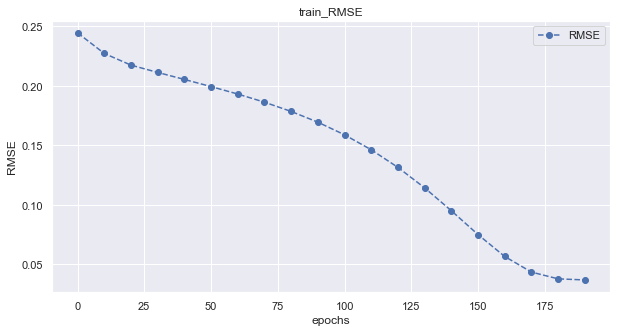

In [18]:

fig = plt.figure(figsize=(10,5))

    # Plot accuracy
plt.plot(epoq,los,'bo--', label = "RMSE")
    #plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
plt.title("train_RMSE")
plt.ylabel("RMSE")
plt.xlabel("epochs")
plt.legend()
plt.show()

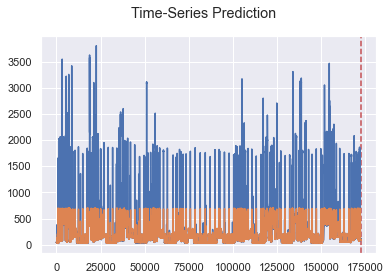

In [20]:
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)
train_size=len(testX)
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [21]:
n=0
for i in range(len (dataY_plot)):
    if np.abs(data_predict[i]-dataY_plot[i])>100:
        n=n+1
        print(dataY_plot[i],'Surconsommation')
    else:
        print(dataY_plot[i],'normal')
print(n)

[39.8] normal
[49.5] normal
[40.4] normal
[47.300003] normal
[39.4] normal
[48.699997] normal
[41.199997] normal
[45.6] normal
[41.1] normal
[47.4] normal
[42.3] normal
[46.1] normal
[47.800003] normal
[39.5] normal
[49.6] normal
[44.899998] normal
[40.600002] normal
[51.] normal
[39.9] normal
[48.1] normal
[40.8] normal
[45.5] normal
[45.5] normal
[42.4] normal
[49.1] normal
[41.3] normal
[47.999996] normal
[45.8] normal
[42.7] normal
[51.2] normal
[40.7] normal
[47.600002] normal
[43.100002] normal
[42.5] normal
[46.7] normal
[39.7] normal
[47.2] normal
[39.9] normal
[51.4] normal
[41.399998] normal
[50.100002] normal
[38.8] normal
[49.3] normal
[40.2] normal
[49.4] normal
[40.8] normal
[47.999996] normal
[40.2] normal
[47.600002] normal
[39.1] normal
[48.1] normal
[43.5] normal
[42.2] normal
[49.5] normal
[40.899998] normal
[44.899998] normal
[47.300003] normal
[38.9] normal
[49.1] normal
[45.] normal
[37.100002] normal
[49.5] normal
[44.300003] normal
[42.] normal
[49.8] normal
[41

[66.799995] normal
[42.5] normal
[35.9] normal
[29.9] normal
[29.500002] normal
[35.1] normal
[30.5] normal
[28.] normal
[33.100002] normal
[27.300001] normal
[38.] normal
[38.399998] normal
[33.5] normal
[42.] normal
[38.9] normal
[33.9] normal
[42.7] normal
[34.] normal
[40.600002] normal
[33.100002] normal
[30.6] normal
[39.] normal
[38.9] normal
[40.5] normal
[37.5] normal
[33.9] normal
[33.100002] normal
[39.4] normal
[41.3] normal
[37.100002] normal
[31.8] normal
[41.199997] normal
[39.8] normal
[34.600002] normal
[39.1] normal
[40.100002] normal
[33.100002] normal
[36.9] normal
[26.4] normal
[27.300001] normal
[36.9] normal
[26.800001] normal
[22.9] normal
[32.1] normal
[33.7] normal
[35.1] normal
[39.600002] normal
[34.7] normal
[39.8] normal
[34.7] normal
[40.7] normal
[40.7] normal
[45.199997] normal
[40.999996] normal
[47.] normal
[40.] normal
[48.699997] normal
[38.9] normal
[47.] normal
[45.] normal
[40.100002] normal
[46.9] normal
[40.8] normal
[46.600002] normal
[43.5] n

[1656.7999] Surconsommation
[1667.9999] Surconsommation
[1666.1] Surconsommation
[1666.2] Surconsommation
[1665.3999] Surconsommation
[1663.7] Surconsommation
[1670.1] Surconsommation
[1669.8999] Surconsommation
[1677.1] Surconsommation
[1678.4999] Surconsommation
[1673.4999] Surconsommation
[1674.3] Surconsommation
[1679.5] Surconsommation
[1672.4] Surconsommation
[1660.2999] Surconsommation
[1674.7999] Surconsommation
[1671.6001] Surconsommation
[1672.5] Surconsommation
[1666.4] Surconsommation
[1686.4] Surconsommation
[1677.2] Surconsommation
[1676.5] Surconsommation
[1891.8] Surconsommation
[2017.5] Surconsommation
[2014.2] Surconsommation
[1993.9999] Surconsommation
[1999.4] Surconsommation
[2001.3999] Surconsommation
[2000.5] Surconsommation
[1985.7999] Surconsommation
[1991.] Surconsommation
[1995.] Surconsommation
[1989.7] Surconsommation
[1992.1] Surconsommation
[1994.4] Surconsommation
[1999.3] Surconsommation
[2002.] Surconsommation
[2005.3] Surconsommation
[2000.7999] Surco

[419.6] normal
[433.5] normal
[434.10004] normal
[424.90002] normal
[435.60004] normal
[440.80002] normal
[432.30002] normal
[447.5] normal
[444.4] normal
[442.50003] normal
[440.7] normal
[434.40002] normal
[424.6] normal
[439.00003] normal
[449.60004] normal
[430.00003] normal
[436.7] normal
[431.3] normal
[434.6] normal
[436.1] normal
[431.60004] normal
[433.2] normal
[442.6] normal
[429.6] normal
[437.7] normal
[440.4] normal
[74.5] Surconsommation
[85.49999] Surconsommation
[74.1] Surconsommation
[82.2] Surconsommation
[78.2] normal
[76.2] normal
[86.9] normal
[77.4] normal
[78.299995] normal
[86.5] normal
[86.9] normal
[81.5] normal
[83.6] normal
[82.2] normal
[76.] normal
[86.7] normal
[74.3] normal
[81.7] normal
[81.799995] normal
[76.6] normal
[85.1] normal
[92.6] normal
[76.6] normal
[80.799995] normal
[84.100006] normal
[79.5] normal
[81.399994] normal
[76.2] normal
[78.8] normal
[85.899994] normal
[83.9] normal
[81.6] normal
[88.7] normal
[88.5] normal
[81.99999] normal
[91

[391.] normal
[394.] normal
[418.50003] normal
[432.1] normal
[434.5] normal
[440.50003] normal
[432.2] normal
[445.2] normal
[443.30002] normal
[441.80002] normal
[451.20004] normal
[447.2] normal
[452.2] normal
[456.7] normal
[431.90002] normal
[426.50003] normal
[410.7] normal
[408.2] normal
[401.90002] normal
[395.] normal
[384.7] normal
[372.7] normal
[405.] normal
[414.80002] normal
[427.80002] normal
[427.7] normal
[431.7] normal
[428.9] normal
[446.9] normal
[433.30002] normal
[436.60004] normal
[442.30002] normal
[434.90002] normal
[440.50003] normal
[454.7] normal
[446.6] normal
[444.60004] normal
[435.4] normal
[417.] normal
[432.9] normal
[423.1] normal
[400.20004] normal
[391.] normal
[393.1] normal
[388.70004] normal
[432.50003] normal
[437.80002] normal
[429.2] normal
[437.30002] normal
[439.4] normal
[454.2] normal
[438.6] normal
[448.6] normal
[452.10004] normal
[444.80002] normal
[442.] normal
[451.80002] normal
[443.90002] normal
[453.80002] normal
[440.30002] normal

[1708.8] Surconsommation
[1714.8999] Surconsommation
[1707.] Surconsommation
[1718.] Surconsommation
[1707.9] Surconsommation
[1711.2999] Surconsommation
[1717.7999] Surconsommation
[1720.1] Surconsommation
[1723.] Surconsommation
[1708.9] Surconsommation
[1710.7001] Surconsommation
[1715.8999] Surconsommation
[1703.2] Surconsommation
[1707.7] Surconsommation
[1708.] Surconsommation
[1701.6] Surconsommation
[1693.4] Surconsommation
[1706.5] Surconsommation
[1706.7999] Surconsommation
[1706.1] Surconsommation
[1699.1] Surconsommation
[1704.7] Surconsommation
[1712.2] Surconsommation
[1707.9] Surconsommation
[1693.6] Surconsommation
[1690.7001] Surconsommation
[1701.4] Surconsommation
[1700.] Surconsommation
[1688.7] Surconsommation
[1701.] Surconsommation
[1692.] Surconsommation
[1699.6] Surconsommation
[1689.8999] Surconsommation
[1697.2999] Surconsommation
[1703.7] Surconsommation
[1705.] Surconsommation
[1696.4] Surconsommation
[1693.7] Surconsommation
[1707.2] Surconsommation
[1697.

[2026.2999] Surconsommation
[2035.2] Surconsommation
[2028.] Surconsommation
[1125.2] Surconsommation
[385.50003] Surconsommation
[376.80002] Surconsommation
[383.80002] Surconsommation
[386.80002] Surconsommation
[380.3] normal
[387.7] normal
[383.90002] normal
[374.6] normal
[366.1] normal
[350.5] normal
[357.] normal
[360.70004] normal
[353.2] normal
[368.] normal
[360.5] normal
[369.00003] normal
[357.] normal
[369.2] normal
[359.8] normal
[365.1] normal
[365.60004] normal
[356.2] normal
[368.] normal
[362.] normal
[359.7] normal
[364.6] normal
[371.40002] normal
[361.7] normal
[358.50003] normal
[363.40002] normal
[1301.2] Surconsommation
[1369.8999] Surconsommation
[1435.7999] Surconsommation
[1403.1] Surconsommation
[1380.2001] Surconsommation
[1370.5] Surconsommation
[1352.6] Surconsommation
[1362.8] Surconsommation
[1359.2001] Surconsommation
[1363.3999] Surconsommation
[1354.1] Surconsommation
[1349.9] Surconsommation
[1344.5] Surconsommation
[1335.6] Surconsommation
[1323.39

[318.80002] normal
[300.6] normal
[299.30002] normal
[303.5] normal
[300.6] normal
[300.30002] normal
[299.30002] normal
[299.30002] normal
[296.2] normal
[296.90002] normal
[294.09998] normal
[291.7] normal
[291.7] normal
[287.8] normal
[287.7] normal
[285.9] normal
[286.19998] normal
[281.8] normal
[287.4] normal
[283.1] normal
[288.] normal
[280.9] normal
[283.1] normal
[279.80002] normal
[292.3] normal
[284.5] normal
[294.6] normal
[287.7] normal
[288.] normal
[290.5] normal
[287.9] normal
[284.6] normal
[285.6] normal
[281.3] normal
[289.7] normal
[282.59998] normal
[285.6] normal
[286.1] normal
[286.9] normal
[287.09998] normal
[286.1] normal
[286.9] normal
[285.9] normal
[284.8] normal
[285.3] normal
[283.3] normal
[280.] normal
[279.] normal
[278.6] normal
[277.] normal
[278.6] normal
[278.] normal
[279.4] normal
[278.7] normal
[280.3] normal
[281.6] normal
[280.9] normal
[270.1] normal
[284.5] normal
[280.1] normal
[269.6] normal
[277.] normal
[272.19998] normal
[279.] normal


[140.8] normal
[142.09999] normal
[141.2] normal
[141.7] normal
[141.8] normal
[139.7] normal
[142.4] normal
[142.3] normal
[141.2] normal
[142.3] normal
[142.3] normal
[142.4] normal
[141.6] normal
[142.9] normal
[140.09999] normal
[143.2] normal
[142.9] normal
[141.6] normal
[142.3] normal
[142.7] normal
[146.1] normal
[142.5] normal
[142.7] normal
[141.5] normal
[142.09999] normal
[142.09999] normal
[141.6] normal
[142.09999] normal
[141.5] normal
[142.09999] normal
[142.9] normal
[141.5] normal
[141.4] normal
[142.8] normal
[142.7] normal
[141.7] normal
[141.5] normal
[142.5] normal
[143.7] normal
[140.9] normal
[141.6] normal
[142.9] normal
[142.4] normal
[140.5] normal
[141.09999] normal
[143.4] normal
[141.2] normal
[140.7] normal
[141.09999] normal
[149.] normal
[140.2] normal
[143.] normal
[139.59999] normal
[143.2] normal
[141.5] normal
[141.5] normal
[140.7] normal
[133.9] normal
[135.6] normal
[151.3] normal
[134.] normal
[140.4] normal
[141.8] normal
[141.29999] normal
[13

[146.59999] normal
[145.8] normal
[145.90001] normal
[149.6] normal
[145.] normal
[147.7] normal
[145.50002] normal
[145.4] normal
[144.9] normal
[145.7] normal
[144.9] normal
[146.] normal
[1807.1] Surconsommation
[1787.9] Surconsommation
[1782.] Surconsommation
[1779.1] Surconsommation
[1780.2] Surconsommation
[1775.8] Surconsommation
[1778.7] Surconsommation
[1773.] Surconsommation
[1775.3] Surconsommation
[1775.2] Surconsommation
[1777.2999] Surconsommation
[1781.] Surconsommation
[1778.] Surconsommation
[1779.1] Surconsommation
[1782.2001] Surconsommation
[1778.2] Surconsommation
[1779.5] Surconsommation
[1780.6] Surconsommation
[1779.9999] Surconsommation
[1776.3999] Surconsommation
[1779.6] Surconsommation
[1779.8] Surconsommation
[1776.3999] Surconsommation
[1773.4] Surconsommation
[1773.9] Surconsommation
[1778.5] Surconsommation
[1780.7] Surconsommation
[1778.2] Surconsommation
[1778.6001] Surconsommation
[1780.4999] Surconsommation
[1780.1] Surconsommation
[1785.4999] Surcon

[45.199997] normal
[43.600002] normal
[46.3] normal
[41.6] normal
[40.4] normal
[41.6] normal
[43.600002] normal
[44.8] normal
[43.9] normal
[49.3] normal
[51.8] normal
[46.600002] normal
[43.100002] normal
[43.] normal
[42.7] normal
[41.399998] normal
[38.9] normal
[39.1] normal
[43.100002] normal
[41.3] normal
[42.8] normal
[44.8] normal
[48.3] normal
[46.4] normal
[47.100002] normal
[48.6] normal
[46.5] normal
[43.600002] normal
[40.899998] normal
[43.800003] normal
[40.7] normal
[37.699997] normal
[41.5] normal
[45.3] normal
[47.800003] normal
[48.6] normal
[48.1] normal
[49.6] normal
[45.8] normal
[43.2] normal
[41.899998] normal
[42.] normal
[41.7] normal
[40.100002] normal
[39.8] normal
[44.] normal
[46.5] normal
[48.199997] normal
[46.8] normal
[50.100002] normal
[46.4] normal
[44.100002] normal
[41.8] normal
[41.8] normal
[41.6] normal
[42.7] normal
[43.100002] normal
[47.4] normal
[48.899998] normal
[48.1] normal
[45.8] normal
[46.2] normal
[47.100002] normal
[46.3] normal
[5

[48.3] normal
[42.3] normal
[39.8] normal
[47.4] normal
[45.9] normal
[39.5] normal
[46.1] normal
[45.199997] normal
[41.199997] normal
[48.3] normal
[43.3] normal
[42.2] normal
[47.999996] normal
[39.4] normal
[48.699997] normal
[42.] normal
[46.600002] normal
[42.2] normal
[48.5] normal
[42.9] normal
[40.100002] normal
[49.2] normal
[45.1] normal
[40.7] normal
[45.9] normal
[46.9] normal
[38.5] normal
[44.] normal
[50.100002] normal
[39.1] normal
[42.4] normal
[49.9] normal
[43.3] normal
[42.1] normal
[49.] normal
[41.1] normal
[42.7] normal
[48.699997] normal
[39.600002] normal
[48.3] normal
[40.8] normal
[44.] normal
[48.1] normal
[42.6] normal
[41.3] normal
[48.199997] normal
[42.9] normal
[39.3] normal
[48.1] normal
[47.] normal
[40.300003] normal
[48.899998] normal
[42.6] normal
[42.6] normal
[48.399998] normal
[42.1] normal
[40.899998] normal
[48.399998] normal
[44.] normal
[42.2] normal
[49.3] normal
[41.899998] normal
[44.8] normal
[47.899998] normal
[41.899998] normal
[51.49

[40.4] normal
[40.7] normal
[49.6] normal
[45.7] normal
[39.8] normal
[42.3] normal
[49.9] normal
[45.5] normal
[39.3] normal
[46.600002] normal
[48.6] normal
[40.8] normal
[40.999996] normal
[48.8] normal
[45.8] normal
[40.4] normal
[47.4] normal
[44.] normal
[41.199997] normal
[48.5] normal
[43.100002] normal
[40.300003] normal
[48.899998] normal
[40.600002] normal
[44.8] normal
[47.5] normal
[40.999996] normal
[48.8] normal
[41.6] normal
[45.3] normal
[44.699997] normal
[43.2] normal
[44.399998] normal
[40.899998] normal
[47.2] normal
[42.1] normal
[47.] normal
[42.9] normal
[45.199997] normal
[43.4] normal
[44.6] normal
[46.2] normal
[40.999996] normal
[46.5] normal
[40.2] normal
[49.1] normal
[40.100002] normal
[48.8] normal
[38.399998] normal
[50.100002] normal
[41.3] normal
[50.100002] normal
[39.8] normal
[50.9] normal
[40.2] normal
[46.9] normal
[45.399998] normal
[40.7] normal
[48.8] normal
[42.9] normal
[40.7] normal
[50.] normal
[40.7] normal
[47.5] normal
[40.300003] norma

[40.7] normal
[42.9] normal
[47.600002] normal
[49.] normal
[47.300003] normal
[40.899998] normal
[40.8] normal
[45.7] normal
[49.5] normal
[49.4] normal
[44.100002] normal
[40.5] normal
[39.1] normal
[43.800003] normal
[48.399998] normal
[49.7] normal
[44.499996] normal
[41.7] normal
[40.4] normal
[42.9] normal
[45.9] normal
[45.3] normal
[45.5] normal
[47.100002] normal
[42.7] normal
[41.8] normal
[39.600002] normal
[39.600002] normal
[39.9] normal
[40.2] normal
[42.3] normal
[42.2] normal
[41.899998] normal
[45.3] normal
[44.2] normal
[43.7] normal
[43.2] normal
[41.5] normal
[42.1] normal
[45.1] normal
[48.399998] normal
[48.3] normal
[45.6] normal
[41.8] normal
[51.499996] normal
[41.399998] normal
[46.3] normal
[45.8] normal
[41.1] normal
[39.600002] normal
[38.7] normal
[46.3] normal
[49.1] normal
[47.100002] normal
[44.300003] normal
[41.5] normal
[43.2] normal
[48.3] normal
[39.4] normal
[47.7] normal
[40.5] normal
[47.800003] normal
[42.1] normal
[46.600002] normal
[49.2] nor

[42.1] normal
[48.399998] normal
[40.2] normal
[45.3] normal
[48.399998] normal
[40.300003] normal
[48.1] normal
[39.8] normal
[47.899998] normal
[41.399998] normal
[43.600002] normal
[44.2] normal
[43.4] normal
[47.600002] normal
[40.] normal
[50.5] normal
[40.300003] normal
[49.2] normal
[39.8] normal
[47.100002] normal
[43.4] normal
[44.300003] normal
[49.3] normal
[38.6] normal
[46.] normal
[45.1] normal
[37.8] normal
[50.9] normal
[39.9] normal
[47.600002] normal
[41.399998] normal
[46.9] normal
[42.9] normal
[43.9] normal
[45.7] normal
[39.3] normal
[49.3] normal
[42.2] normal
[41.399998] normal
[49.6] normal
[41.199997] normal
[42.] normal
[49.1] normal
[39.2] normal
[48.5] normal
[38.2] normal
[48.899998] normal
[41.3] normal
[42.7] normal
[44.699997] normal
[40.] normal
[50.7] normal
[41.7] normal
[46.9] normal
[40.899998] normal
[46.2] normal
[44.] normal
[44.6] normal
[43.4] normal
[44.300003] normal
[43.2] normal
[45.9] normal
[41.3] normal
[46.5] normal
[39.7] normal
[47.3

[186.40001] normal
[194.6] normal
[188.2] normal
[188.2] normal
[191.59999] normal
[187.4] normal
[192.1] normal
[185.9] normal
[189.09999] normal
[191.8] normal
[185.9] normal
[193.2] normal
[73.] Surconsommation
[79.] normal
[75.6] normal
[79.] normal
[515.10004] Surconsommation
[1540.4] Surconsommation
[1524.5] Surconsommation
[1536.1] Surconsommation
[1526.3999] Surconsommation
[127.49999] Surconsommation
[1526.2] Surconsommation
[71.2] Surconsommation
[75.5] Surconsommation
[78.299995] Surconsommation
[71.] Surconsommation
[81.2] normal
[76.3] normal
[72.7] normal
[80.] normal
[69.200005] normal
[80.5] normal
[73.9] normal
[80.] normal
[73.1] normal
[78.2] normal
[76.4] normal
[73.1] normal
[72.7] normal
[78.6] normal
[69.600006] normal
[79.200005] normal
[74.2] normal
[71.5] normal
[81.6] normal
[75.399994] normal
[71.4] normal
[79.] normal
[76.5] normal
[71.8] normal
[79.8] normal
[76.4] normal
[70.4] normal
[81.7] normal
[152.] normal
[158.70001] normal
[159.8] normal
[158.7000

[2117.9] Surconsommation
[2123.6] Surconsommation
[2122.7] Surconsommation
[2142.] Surconsommation
[2154.9] Surconsommation
[2168.8] Surconsommation
[2162.8] Surconsommation
[2181.9] Surconsommation
[2170.] Surconsommation
[2188.7] Surconsommation
[2188.7] Surconsommation
[2183.2] Surconsommation
[554.10004] normal
[557.2] normal
[547.10004] normal
[549.1] normal
[543.2] normal
[544.5] normal
[544.5] normal
[546.6] normal
[557.] normal
[556.7] normal
[550.9] normal
[550.2] normal
[559.7] normal
[567.1] normal
[553.5] normal
[559.9] normal
[564.2] normal
[555.] normal
[551.4] normal
[549.60004] normal
[554.] normal
[559.5] normal
[566.8] normal
[564.] normal
[567.8] normal
[532.] normal
[524.7] normal
[523.3] normal
[509.00003] normal
[392.2] Surconsommation
[393.1] normal
[383.80002] normal
[410.] normal
[421.30002] normal
[415.10004] normal
[433.7] normal
[427.80002] normal
[425.90002] normal
[438.7] normal
[425.2] normal
[432.50003] normal
[442.20004] normal
[431.3] normal
[429.6] no

[110.3] normal
[111.09999] normal
[109.299995] normal
[106.] normal
[123.799995] normal
[114.2] normal
[106.7] normal
[111.6] normal
[110.2] normal
[111.2] normal
[110.6] normal
[111.2] normal
[112.299995] normal
[110.3] normal
[108.2] normal
[97.6] normal
[103.399994] normal
[96.6] normal
[94.1] normal
[102.299995] normal
[99.] normal
[99.1] normal
[97.7] normal
[99.899994] normal
[91.8] normal
[99.899994] normal
[117.5] normal
[102.6] normal
[103.5] normal
[98.49999] normal
[92.1] normal
[116.2] normal
[104.299995] normal
[101.9] normal
[107.59999] normal
[103.700005] normal
[107.] normal
[106.4] normal
[107.5] normal
[97.2] normal
[102.299995] normal
[107.299995] normal
[103.3] normal
[106.4] normal
[112.4] normal
[108.7] normal
[111.09999] normal
[113.899994] normal
[106.] normal
[114.] normal
[122.299995] normal
[107.200005] normal
[121.1] normal
[114.7] normal
[126.299995] normal
[114.899994] normal
[114.799995] normal
[124.6] normal
[120.8] normal
[124.5] normal
[112.] normal
[1

[94.399994] normal
[87.9] normal
[94.299995] normal
[133.7] normal
[114.799995] normal
[129.09999] normal
[129.] normal
[123.99999] normal
[124.5] normal
[124.7] normal
[130.] normal
[134.8] normal
[131.2] normal
[120.8] normal
[126.7] normal
[125.299995] normal
[122.1] normal
[130.79999] normal
[129.7] normal
[122.1] normal
[122.1] normal
[126.799995] normal
[123.9] normal
[123.99999] normal
[131.1] normal
[123.6] normal
[124.5] normal
[126.4] normal
[129.59999] normal
[137.2] normal
[135.7] normal
[126.2] normal
[138.8] normal
[130.59999] normal
[122.7] normal
[122.399994] normal
[128.5] normal
[128.9] normal
[123.399994] normal
[127.4] normal
[119.4] normal
[127.7] normal
[127.4] normal
[119.2] normal
[124.5] normal
[124.399994] normal
[122.799995] normal
[118.799995] normal
[127.6] normal
[116.299995] normal
[121.5] normal
[126.49999] normal
[117.2] normal
[122.1] normal
[125.2] normal
[115.9] normal
[127.1] normal
[128.3] normal
[117.6] normal
[126.2] normal
[131.59999] normal
[12

[2360.2002] Surconsommation
[2348.3] Surconsommation
[2400.8] Surconsommation
[2412.2] Surconsommation
[2444.4001] Surconsommation
[2458.5] Surconsommation
[2466.7002] Surconsommation
[2478.6003] Surconsommation
[2484.1] Surconsommation
[2435.1] Surconsommation
[2409.5002] Surconsommation
[2400.1] Surconsommation
[2403.1] Surconsommation
[2387.9001] Surconsommation
[2380.4] Surconsommation
[2380.6] Surconsommation
[2364.1] Surconsommation
[2361.5002] Surconsommation
[2357.] Surconsommation
[2357.5] Surconsommation
[2348.9] Surconsommation
[2346.3] Surconsommation
[2358.7002] Surconsommation
[2350.1] Surconsommation
[2349.1] Surconsommation
[2347.4001] Surconsommation
[2352.0002] Surconsommation
[2348.8] Surconsommation
[2344.8] Surconsommation
[2357.9001] Surconsommation
[2352.9001] Surconsommation
[2410.9] Surconsommation
[2412.5002] Surconsommation
[2433.3003] Surconsommation
[2453.9001] Surconsommation
[2456.6] Surconsommation
[2472.4] Surconsommation
[2467.] Surconsommation
[2417.5

[144.70001] normal
[134.4] normal
[133.09999] normal
[146.90001] normal
[125.] normal
[134.29999] normal
[130.7] normal
[127.49999] normal
[121.799995] normal
[130.7] normal
[134.8] normal
[141.5] normal
[141.9] normal
[129.59999] normal
[124.799995] normal
[134.5] normal
[136.79999] normal
[141.7] normal
[134.2] normal
[136.9] normal
[126.6] normal
[134.2] normal
[132.4] normal
[132.29999] normal
[140.7] normal
[134.09999] normal
[138.8] normal
[135.79999] normal
[405.30002] Surconsommation
[491.80002] Surconsommation
[492.80002] Surconsommation
[478.1] Surconsommation
[481.5] normal
[488.80002] normal
[480.7] normal
[480.40002] normal
[485.7] normal
[479.20004] normal
[495.00003] normal
[478.] normal
[486.80002] normal
[484.7] normal
[481.90002] normal
[486.1] normal
[489.30002] normal
[485.2] normal
[490.6] normal
[484.5] normal
[487.1] normal
[488.80002] normal
[485.2] normal
[490.00003] normal
[487.50003] normal
[498.9] normal
[481.90002] normal
[488.] normal
[491.7] normal
[486.2

[134.2] normal
[132.2] normal
[133.59999] normal
[131.59999] normal
[125.399994] normal
[121.7] normal
[128.5] normal
[120.49999] normal
[126.2] normal
[132.7] normal
[131.7] normal
[133.29999] normal
[131.5] normal
[135.09999] normal
[132.4] normal
[134.2] normal
[130.3] normal
[129.2] normal
[128.79999] normal
[132.] normal
[126.899994] normal
[126.09999] normal
[135.5] normal
[179.40001] normal
[123.99999] normal
[159.] normal
[159.90001] normal
[156.6] normal
[159.4] normal
[158.59999] normal
[152.90001] normal
[154.20001] normal
[156.09999] normal
[154.8] normal
[156.6] normal
[156.4] normal
[157.90001] normal
[155.90001] normal
[158.40001] normal
[156.8] normal
[151.40001] normal
[158.40001] normal
[159.6] normal
[164.9] normal
[157.7] normal
[156.3] normal
[165.2] normal
[161.6] normal
[155.2] normal
[156.5] normal
[155.5] normal
[159.90001] normal
[157.5] normal
[156.] normal
[154.4] normal
[156.9] normal
[158.2] normal
[157.79999] normal
[155.90001] normal
[156.9] normal
[156.

[140.09999] normal
[140.59999] normal
[138.9] normal
[139.2] normal
[138.1] normal
[138.4] normal
[138.9] normal
[140.5] normal
[138.7] normal
[140.9] normal
[139.] normal
[139.7] normal
[138.2] normal
[140.09999] normal
[139.7] normal
[148.] normal
[145.6] normal
[138.9] normal
[138.7] normal
[139.5] normal
[140.] normal
[141.4] normal
[139.4] normal
[139.4] normal
[137.4] normal
[139.3] normal
[136.59999] normal
[138.8] normal
[140.8] normal
[140.7] normal
[139.4] normal
[140.8] normal
[140.7] normal
[139.] normal
[141.9] normal
[140.29999] normal
[139.2] normal
[139.3] normal
[140.5] normal
[139.4] normal
[140.9] normal
[142.6] normal
[139.7] normal
[139.9] normal
[139.59999] normal
[138.7] normal
[139.3] normal
[142.09999] normal
[139.8] normal
[140.7] normal
[142.2] normal
[137.79999] normal
[139.5] normal
[138.5] normal
[138.5] normal
[140.9] normal
[140.29999] normal
[139.1] normal
[139.8] normal
[138.8] normal
[139.59999] normal
[140.4] normal
[138.7] normal
[138.] normal
[136.

[141.] normal
[140.8] normal
[143.59999] normal
[143.5] normal
[142.] normal
[140.8] normal
[143.79999] normal
[142.7] normal
[143.4] normal
[141.9] normal
[142.7] normal
[143.] normal
[141.8] normal
[140.59999] normal
[141.9] normal
[142.] normal
[144.09999] normal
[146.5] normal
[142.3] normal
[141.5] normal
[144.] normal
[142.6] normal
[143.5] normal
[144.3] normal
[142.6] normal
[141.7] normal
[142.] normal
[142.5] normal
[141.8] normal
[143.2] normal
[142.2] normal
[142.] normal
[142.7] normal
[142.3] normal
[143.] normal
[142.6] normal
[141.5] normal
[141.5] normal
[141.7] normal
[141.9] normal
[144.8] normal
[142.] normal
[143.7] normal
[142.3] normal
[141.] normal
[142.8] normal
[142.6] normal
[143.2] normal
[142.5] normal
[142.8] normal
[142.2] normal
[141.8] normal
[142.] normal
[141.6] normal
[142.2] normal
[142.2] normal
[142.09999] normal
[141.29999] normal
[142.] normal
[140.5] normal
[142.8] normal
[142.2] normal
[143.3] normal
[140.29999] normal
[140.4] normal
[140.2999

[154.4] normal
[161.9] normal
[154.09999] normal
[159.90001] normal
[159.2] normal
[152.6] normal
[163.59999] normal
[156.20001] normal
[161.8] normal
[158.09999] normal
[159.6] normal
[157.79999] normal
[157.3] normal
[160.] normal
[152.7] normal
[161.6] normal
[151.8] normal
[158.] normal
[157.4] normal
[39.1] Surconsommation
[47.2] normal
[37.5] normal
[45.1] normal
[47.4] normal
[38.9] normal
[46.] normal
[42.9] normal
[42.6] normal
[46.600002] normal
[37.100002] normal
[44.100002] normal
[45.5] normal
[39.2] normal
[39.5] normal
[46.4] normal
[34.600002] normal
[41.1] normal
[40.7] normal
[39.1] normal
[40.999996] normal
[40.300003] normal
[47.100002] normal
[46.2] normal
[40.4] normal
[39.5] normal
[47.] normal
[45.9] normal
[36.] normal
[40.999996] normal
[47.100002] normal
[44.300003] normal
[44.899998] normal
[39.] normal
[38.8] normal
[44.399998] normal
[47.600002] normal
[45.7] normal
[38.3] normal
[37.8] normal
[46.4] normal
[46.4] normal
[42.2] normal
[36.3] normal
[42.8] 

[161.5] normal
[156.] normal
[162.90001] normal
[152.6] normal
[161.3] normal
[155.1] normal
[160.40001] normal
[158.] normal
[158.] normal
[160.9] normal
[154.7] normal
[163.3] normal
[155.1] normal
[159.4] normal
[161.20001] normal
[152.8] normal
[160.8] normal
[161.09999] normal
[154.20001] normal
[162.40001] normal
[153.8] normal
[159.6] normal
[160.] normal
[158.3] normal
[159.90001] normal
[153.5] normal
[164.6] normal
[153.8] normal
[160.59999] normal
[163.] normal
[161.5] normal
[154.09999] normal
[154.9] normal
[159.8] normal
[161.4] normal
[156.09999] normal
[154.09999] normal
[162.90001] normal
[160.59999] normal
[156.5] normal
[155.8] normal
[163.99998] normal
[154.20001] normal
[153.8] normal
[163.8] normal
[158.] normal
[155.8] normal
[161.20001] normal
[156.5] normal
[154.9] normal
[163.99998] normal
[155.] normal
[161.09999] normal
[158.9] normal
[155.2] normal
[162.8] normal
[153.2] normal
[161.9] normal
[154.] normal
[164.49998] normal
[154.20001] normal
[161.8] norma

[156.4] normal
[156.] normal
[164.1] normal
[154.7] normal
[162.8] normal
[159.6] normal
[156.] normal
[161.09999] normal
[154.09999] normal
[162.6] normal
[155.] normal
[162.8] normal
[154.09999] normal
[159.] normal
[162.6] normal
[154.4] normal
[155.29999] normal
[160.40001] normal
[158.40001] normal
[154.7] normal
[162.90001] normal
[156.6] normal
[154.5] normal
[164.2] normal
[162.] normal
[163.] normal
[162.7] normal
[161.] normal
[48.399998] Surconsommation
[46.600002] normal
[44.699997] normal
[40.7] normal
[38.3] normal
[36.5] normal
[44.699997] normal
[49.1] normal
[42.] normal
[38.1] normal
[39.9] normal
[46.9] normal
[45.] normal
[38.3] normal
[43.600002] normal
[45.199997] normal
[38.2] normal
[47.] normal
[38.] normal
[47.600002] normal
[38.5] normal
[49.5] normal
[38.1] normal
[47.899998] normal
[38.8] normal
[50.] normal
[38.6] normal
[47.7] normal
[38.399998] normal
[39.3] normal
[46.7] normal
[38.6] normal
[43.9] normal
[45.] normal
[39.2] normal
[47.5] normal
[38.8] 

[164.7] normal
[154.3] normal
[164.79999] normal
[152.2] normal
[157.3] normal
[159.] normal
[152.90001] normal
[154.09999] normal
[162.1] normal
[153.8] normal
[158.9] normal
[153.9] normal
[160.8] normal
[153.8] normal
[160.1] normal
[159.50002] normal
[155.40001] normal
[164.2] normal
[159.8] normal
[153.2] normal
[157.90001] normal
[166.49998] normal
[160.5] normal
[155.1] normal
[164.3] normal
[155.6] normal
[162.2] normal
[158.2] normal
[159.50002] normal
[160.7] normal
[157.90001] normal
[160.59999] normal
[156.3] normal
[159.50002] normal
[158.09999] normal
[152.4] normal
[164.1] normal
[155.29999] normal
[159.1] normal
[161.5] normal
[154.09999] normal
[163.8] normal
[156.20001] normal
[159.3] normal
[159.] normal
[152.50002] normal
[164.2] normal
[155.90001] normal
[160.5] normal
[157.3] normal
[156.3] normal
[160.59999] normal
[156.3] normal
[161.20001] normal
[156.9] normal
[163.] normal
[152.8] normal
[163.70001] normal
[157.5] normal
[162.2] normal
[152.6] normal
[162.6] 

[148.1] normal
[155.1] normal
[153.] normal
[150.4] normal
[156.9] normal
[148.90001] normal
[148.5] normal
[158.9] normal
[150.2] normal
[149.70001] normal
[158.59999] normal
[147.4] normal
[154.09999] normal
[154.6] normal
[151.70001] normal
[158.09999] normal
[154.3] normal
[156.6] normal
[157.7] normal
[150.6] normal
[162.5] normal
[157.4] normal
[155.8] normal
[157.6] normal
[151.8] normal
[161.8] normal
[153.7] normal
[151.40001] normal
[153.7] normal
[155.2] normal
[157.79999] normal
[150.6] normal
[157.2] normal
[158.5] normal
[152.2] normal
[159.8] normal
[153.] normal
[158.5] normal
[158.59999] normal
[153.40001] normal
[160.9] normal
[153.3] normal
[162.1] normal
[152.6] normal
[163.20001] normal
[156.20001] normal
[163.9] normal
[155.90001] normal
[154.] normal
[154.20001] normal
[161.4] normal
[162.8] normal
[156.4] normal
[152.7] normal
[160.2] normal
[158.8] normal
[150.2] normal
[159.7] normal
[156.] normal
[152.3] normal
[162.7] normal
[153.59999] normal
[163.] normal


[145.2] normal
[152.50002] normal
[147.20001] normal
[147.5] normal
[149.] normal
[145.1] normal
[152.3] normal
[148.2] normal
[148.90001] normal
[162.90001] normal
[147.] normal
[153.40001] normal
[147.09999] normal
[140.] normal
[152.6] normal
[148.5] normal
[140.59999] normal
[150.1] normal
[155.40001] normal
[151.70001] normal
[158.3] normal
[151.3] normal
[160.7] normal
[152.3] normal
[161.3] normal
[151.09999] normal
[159.6] normal
[152.4] normal
[160.7] normal
[150.90001] normal
[159.90001] normal
[151.9] normal
[152.7] normal
[159.6] normal
[152.1] normal
[158.8] normal
[156.70001] normal
[150.4] normal
[158.70001] normal
[152.3] normal
[160.1] normal
[154.8] normal
[159.8] normal
[152.4] normal
[159.50002] normal
[158.59999] normal
[151.2] normal
[158.70001] normal
[155.] normal
[151.8] normal
[160.59999] normal
[152.6] normal
[151.59999] normal
[158.09999] normal
[158.70001] normal
[152.50002] normal
[153.8] normal
[161.] normal
[157.4] normal
[151.2] normal
[159.4] normal
[1

[545.9] normal
[542.] normal
[546.4] normal
[551.10004] normal
[534.5] normal
[520.4] normal
[523.] normal
[520.5] normal
[506.] normal
[505.60004] normal
[507.1] normal
[491.2] normal
[493.40002] normal
[524.5] normal
[524.3] normal
[530.5] normal
[546.80005] normal
[543.] normal
[549.30005] normal
[545.8] normal
[542.10004] normal
[543.10004] normal
[551.9] normal
[551.3] normal
[547.] normal
[547.10004] normal
[546.9] normal
[554.10004] normal
[534.2] normal
[532.80005] normal
[526.5] normal
[205.4] Surconsommation
[186.2] Surconsommation
[206.3] Surconsommation
[188.29999] Surconsommation
[195.9] normal
[189.9] normal
[201.4] normal
[193.8] normal
[199.2] normal
[200.59999] normal
[194.49998] normal
[194.4] normal
[195.7] normal
[200.40001] normal
[195.9] normal
[188.59999] normal
[193.59999] normal
[201.49998] normal
[187.79999] normal
[193.2] normal
[188.1] normal
[196.7] normal
[200.40001] normal
[196.7] normal
[200.59999] normal
[197.29999] normal
[203.09999] normal
[201.09999]

[1015.60004] Surconsommation
[1007.89996] Surconsommation
[1010.8] Surconsommation
[1019.2] Surconsommation
[1016.39996] Surconsommation
[994.3] Surconsommation
[995.69995] Surconsommation
[973.7] Surconsommation
[996.99994] Surconsommation
[976.8] Surconsommation
[998.19995] Surconsommation
[981.9] Surconsommation
[966.2] Surconsommation
[989.3] Surconsommation
[1008.5] Surconsommation
[1021.5] Surconsommation
[1027.2999] Surconsommation
[1027.6] Surconsommation
[1040.2001] Surconsommation
[1029.7] Surconsommation
[1038.1] Surconsommation
[1035.4] Surconsommation
[1041.1] Surconsommation
[1042.7999] Surconsommation
[589.] normal
[589.9] normal
[591.7] normal
[593.10004] normal
[589.] normal
[592.69995] normal
[597.89996] normal
[551.2] normal
[572.7] normal
[544.] normal
[559.8] normal
[543.10004] normal
[525.8] normal
[519.2] normal
[557.7] normal
[544.60004] normal
[564.7] normal
[572.8] normal
[568.2] normal
[577.60004] normal
[577.5] normal
[582.69995] normal
[580.7] normal
[554.1

[2229.5] Surconsommation
[2238.8] Surconsommation
[2257.] Surconsommation
[2243.2] Surconsommation
[2238.0999] Surconsommation
[2245.7998] Surconsommation
[2242.] Surconsommation
[2256.3] Surconsommation
[2257.4] Surconsommation
[2249.5999] Surconsommation
[2252.3] Surconsommation
[2252.4] Surconsommation
[2248.8] Surconsommation
[2252.5999] Surconsommation
[2277.8] Surconsommation
[2252.8] Surconsommation
[2259.5] Surconsommation
[2252.2] Surconsommation
[2264.0999] Surconsommation
[2245.9] Surconsommation
[2262.] Surconsommation
[2266.3] Surconsommation
[2276.2998] Surconsommation
[1807.7999] Surconsommation
[1810.9] Surconsommation
[1800.2] Surconsommation
[1801.3] Surconsommation
[1804.4] Surconsommation
[1801.8999] Surconsommation
[1805.8] Surconsommation
[1798.7] Surconsommation
[1801.3] Surconsommation
[1796.8999] Surconsommation
[1806.3999] Surconsommation
[196.99998] Surconsommation
[200.29999] Surconsommation
[207.2] Surconsommation
[195.7] Surconsommation
[220.90001] normal


[323.1] normal
[337.60004] normal
[325.80002] normal
[338.3] normal
[326.7] normal
[330.7] normal
[334.50003] normal
[329.7] normal
[333.90002] normal
[322.7] normal
[335.40002] normal
[336.7] normal
[336.40002] normal
[376.7] normal
[364.6] normal
[339.2] normal
[334.2] normal
[331.8] normal
[338.] normal
[334.6] normal
[340.7] normal
[334.6] normal
[336.5] normal
[340.] normal
[349.30002] normal
[354.2] normal
[332.80002] normal
[383.6] normal
[377.] normal
[362.7] normal
[337.7] normal
[330.40002] normal
[326.90002] normal
[337.7] normal
[331.30002] normal
[331.5] normal
[335.8] normal
[335.30002] normal
[336.90002] normal
[331.6] normal
[337.1] normal
[326.10004] normal
[335.8] normal
[330.30002] normal
[329.6] normal
[336.00003] normal
[326.6] normal
[332.2] normal
[334.7] normal
[332.70004] normal
[337.60004] normal
[327.40002] normal
[334.9] normal
[332.80002] normal
[331.6] normal
[337.30002] normal
[329.6] normal
[340.90002] normal
[334.30002] normal
[324.7] normal
[335.1] nor

[372.80002] normal
[376.1] normal
[376.50003] normal
[385.3] normal
[381.] normal
[374.1] normal
[372.6] normal
[381.1] normal
[364.00003] normal
[357.] normal
[360.2] normal
[356.4] normal
[358.] normal
[362.1] normal
[357.2] normal
[352.50003] normal
[349.] normal
[365.2] normal
[363.40002] normal
[359.10004] normal
[367.40002] normal
[359.6] normal
[359.2] normal
[370.2] normal
[352.90002] normal
[362.6] normal
[358.7] normal
[361.7] normal
[365.7] normal
[360.1] normal
[359.7] normal
[361.7] normal
[355.80002] normal
[365.5] normal
[359.90002] normal
[376.7] normal
[357.40002] normal
[357.1] normal
[361.30002] normal
[361.60004] normal
[361.7] normal
[356.4] normal
[365.5] normal
[357.7] normal
[360.4] normal
[352.] normal
[363.6] normal
[377.] normal
[377.5] normal
[382.90002] normal
[367.6] normal
[355.5] normal
[367.7] normal
[376.30002] normal
[366.40002] normal
[372.50003] normal
[363.6] normal
[370.30002] normal
[361.4] normal
[372.] normal
[368.10004] normal
[358.] normal
[3

[160.5] normal
[161.6] normal
[162.] normal
[160.] normal
[158.3] normal
[158.2] normal
[161.7] normal
[160.] normal
[161.8] normal
[157.1] normal
[158.8] normal
[157.6] normal
[159.3] normal
[159.8] normal
[160.3] normal
[160.7] normal
[160.1] normal
[160.1] normal
[161.6] normal
[158.09999] normal
[159.] normal
[160.1] normal
[161.] normal
[160.3] normal
[160.40001] normal
[160.] normal
[161.8] normal
[158.5] normal
[160.1] normal
[160.40001] normal
[160.9] normal
[160.5] normal
[161.7] normal
[162.29999] normal
[166.9] normal
[160.] normal
[158.70001] normal
[160.8] normal
[159.3] normal
[158.9] normal
[162.29999] normal
[161.4] normal
[161.09999] normal
[160.9] normal
[160.7] normal
[161.7] normal
[160.8] normal
[160.] normal
[159.4] normal
[158.3] normal
[159.4] normal
[160.59999] normal
[159.7] normal
[160.59999] normal
[152.6] normal
[159.3] normal
[161.5] normal
[161.8] normal
[160.40001] normal
[162.29999] normal
[164.1] normal
[162.7] normal
[163.70001] normal
[163.99998] nor

[146.] normal
[144.09999] normal
[145.50002] normal
[144.4] normal
[144.8] normal
[145.4] normal
[145.2] normal
[144.9] normal
[147.] normal
[143.09999] normal
[144.9] normal
[146.3] normal
[144.70001] normal
[151.2] normal
[151.] normal
[146.2] normal
[146.] normal
[144.09999] normal
[145.90001] normal
[145.7] normal
[145.6] normal
[149.4] normal
[141.] normal
[143.2] normal
[144.9] normal
[144.9] normal
[144.2] normal
[145.6] normal
[144.3] normal
[145.4] normal
[144.59999] normal
[145.6] normal
[146.1] normal
[145.6] normal
[145.50002] normal
[145.2] normal
[145.2] normal
[146.1] normal
[143.59999] normal
[144.8] normal
[146.40001] normal
[144.2] normal
[143.79999] normal
[144.9] normal
[146.1] normal
[145.1] normal
[144.8] normal
[143.7] normal
[144.9] normal
[145.] normal
[146.] normal
[146.3] normal
[143.79999] normal
[144.5] normal
[146.90001] normal
[144.9] normal
[145.3] normal
[145.6] normal
[146.90001] normal
[143.7] normal
[145.4] normal
[145.1] normal
[143.59999] normal
[1

[138.59999] normal
[139.4] normal
[137.9] normal
[138.4] normal
[138.3] normal
[139.] normal
[139.5] normal
[137.4] normal
[140.4] normal
[139.5] normal
[136.] normal
[138.9] normal
[138.9] normal
[138.4] normal
[139.59999] normal
[137.79999] normal
[138.4] normal
[139.] normal
[140.29999] normal
[137.7] normal
[137.5] normal
[138.3] normal
[139.1] normal
[139.7] normal
[141.] normal
[140.] normal
[139.3] normal
[141.] normal
[139.7] normal
[140.8] normal
[139.] normal
[139.2] normal
[138.4] normal
[139.] normal
[136.9] normal
[140.4] normal
[139.9] normal
[139.59999] normal
[138.8] normal
[140.09999] normal
[141.4] normal
[138.8] normal
[138.5] normal
[138.3] normal
[138.2] normal
[139.] normal
[139.3] normal
[137.9] normal
[141.] normal
[141.] normal
[140.] normal
[140.5] normal
[138.8] normal
[138.] normal
[138.8] normal
[140.09999] normal
[140.5] normal
[140.] normal
[139.4] normal
[139.9] normal
[139.2] normal
[137.79999] normal
[140.5] normal
[140.09999] normal
[140.4] normal
[14

[49.7] normal
[41.5] normal
[49.8] normal
[42.6] normal
[47.300003] normal
[45.5] normal
[46.9] normal
[43.600002] normal
[49.2] normal
[42.] normal
[50.] normal
[45.1] normal
[48.5] normal
[41.399998] normal
[48.8] normal
[46.4] normal
[42.2] normal
[49.5] normal
[42.1] normal
[44.300003] normal
[47.999996] normal
[41.199997] normal
[52.199997] normal
[41.6] normal
[47.5] normal
[43.9] normal
[46.600002] normal
[45.5] normal
[44.2] normal
[48.399998] normal
[42.3] normal
[51.100002] normal
[43.9] normal
[49.2] normal
[42.5] normal
[47.4] normal
[46.9] normal
[47.2] normal
[42.7] normal
[49.9] normal
[41.5] normal
[51.2] normal
[43.3] normal
[50.100002] normal
[41.3] normal
[50.600002] normal
[44.300003] normal
[45.8] normal
[46.2] normal
[42.4] normal
[51.100002] normal
[40.899998] normal
[49.9] normal
[44.499996] normal
[47.] normal
[45.6] normal
[44.100002] normal
[48.3] normal
[48.3] normal
[43.800003] normal
[48.899998] normal
[41.399998] normal
[50.100002] normal
[42.8] normal
[5

[46.8] normal
[44.399998] normal
[50.7] normal
[43.600002] normal
[53.7] normal
[42.9] normal
[50.7] normal
[41.7] normal
[51.4] normal
[42.5] normal
[51.4] normal
[43.600002] normal
[46.5] normal
[45.9] normal
[47.899998] normal
[45.9] normal
[46.7] normal
[48.699997] normal
[44.] normal
[49.4] normal
[42.9] normal
[49.1] normal
[42.5] normal
[52.199997] normal
[42.8] normal
[53.] normal
[43.] normal
[51.2] normal
[39.4] normal
[53.5] normal
[44.699997] normal
[52.6] normal
[41.8] normal
[50.600002] normal
[41.8] normal
[52.6] normal
[42.2] normal
[48.699997] normal
[46.600002] normal
[46.2] normal
[45.5] normal
[46.4] normal
[46.8] normal
[46.1] normal
[45.7] normal
[44.300003] normal
[51.300003] normal
[42.3] normal
[50.9] normal
[42.9] normal
[50.600002] normal
[50.5] normal
[42.1] normal
[45.] normal
[51.4] normal
[45.9] normal
[42.9] normal
[47.2] normal
[49.5] normal
[50.800003] normal
[49.8] normal
[48.199997] normal
[41.899998] normal
[44.100002] normal
[50.3] normal
[47.5] no

[40.300003] normal
[49.4] normal
[43.7] normal
[45.3] normal
[45.5] normal
[42.8] normal
[52.] normal
[42.6] normal
[49.6] normal
[44.2] normal
[43.9] normal
[49.5] normal
[40.8] normal
[46.9] normal
[47.300003] normal
[40.5] normal
[50.5] normal
[43.3] normal
[44.699997] normal
[50.4] normal
[43.3] normal
[49.1] normal
[41.7] normal
[48.6] normal
[40.4] normal
[48.6] normal
[44.] normal
[47.899998] normal
[44.899998] normal
[44.100002] normal
[48.8] normal
[42.1] normal
[51.2] normal
[45.1] normal
[45.7] normal
[46.2] normal
[42.6] normal
[47.800003] normal
[42.7] normal
[50.4] normal
[43.5] normal
[47.300003] normal
[42.5] normal
[48.899998] normal
[41.1] normal
[51.300003] normal
[40.300003] normal
[49.2] normal
[41.899998] normal
[51.] normal
[40.600002] normal
[51.300003] normal
[41.5] normal
[50.100002] normal
[41.1] normal
[51.] normal
[41.899998] normal
[48.8] normal
[42.4] normal
[48.3] normal
[45.7] normal
[45.5] normal
[49.] normal
[41.5] normal
[44.6] normal
[47.999996] nor

[43.9] normal
[45.5] normal
[50.2] normal
[40.2] normal
[48.3] normal
[47.899998] normal
[41.399998] normal
[50.5] normal
[47.300003] normal
[42.5] normal
[51.2] normal
[41.7] normal
[50.100002] normal
[46.4] normal
[45.1] normal
[49.2] normal
[42.6] normal
[51.300003] normal
[44.399998] normal
[40.2] normal
[45.7] normal
[49.9] normal
[50.800003] normal
[46.9] normal
[39.2] normal
[46.3] normal
[50.2] normal
[48.699997] normal
[48.5] normal
[46.4] normal
[42.3] normal
[41.199997] normal
[44.6] normal
[50.3] normal
[49.4] normal
[49.1] normal
[43.2] normal
[41.199997] normal
[44.899998] normal
[52.3] normal
[49.3] normal
[43.100002] normal
[41.1] normal
[50.600002] normal
[49.] normal
[40.5] normal
[50.100002] normal
[48.699997] normal
[43.] normal
[48.899998] normal
[45.7] normal
[45.7] normal
[43.] normal
[50.2] normal
[41.7] normal
[41.399998] normal
[42.9] normal
[48.699997] normal
[51.4] normal
[51.300003] normal
[45.199997] normal
[44.100002] normal
[42.] normal
[46.1] normal
[49

[45.9] normal
[45.5] normal
[48.699997] normal
[47.2] normal
[39.9] normal
[48.5] normal
[47.600002] normal
[42.6] normal
[50.5] normal
[41.5] normal
[48.899998] normal
[46.1] normal
[42.9] normal
[52.] normal
[43.] normal
[50.3] normal
[42.7] normal
[51.300003] normal
[43.] normal
[50.2] normal
[43.2] normal
[49.7] normal
[42.] normal
[48.3] normal
[48.199997] normal
[48.199997] normal
[45.7] normal
[44.899998] normal
[42.4] normal
[40.100002] normal
[40.7] normal
[43.4] normal
[46.3] normal
[49.4] normal
[49.8] normal
[49.] normal
[43.800003] normal
[40.999996] normal
[41.3] normal
[46.] normal
[49.5] normal
[52.5] normal
[45.5] normal
[41.5] normal
[42.5] normal
[49.6] normal
[45.7] normal
[42.9] normal
[48.6] normal
[43.4] normal
[45.3] normal
[48.6] normal
[42.5] normal
[51.] normal
[42.7] normal
[51.2] normal
[41.7] normal
[51.699997] normal
[40.300003] normal
[49.5] normal
[42.6] normal
[46.7] normal
[50.] normal
[47.2] normal
[41.899998] normal
[44.399998] normal
[51.2] normal


[178.9] normal
[180.] normal
[182.19998] normal
[195.9] normal
[195.40001] normal
[192.9] normal
[199.9] normal
[192.4] normal
[193.5] normal
[188.] normal
[188.5] normal
[188.40001] normal
[192.1] normal
[196.3] normal
[198.4] normal
[195.9] normal
[194.49998] normal
[187.7] normal
[185.49998] normal
[187.4] normal
[188.2] normal
[195.1] normal
[194.4] normal
[195.9] normal
[195.9] normal
[189.09999] normal
[185.79999] normal
[188.29999] normal
[187.9] normal
[191.99998] normal
[194.09999] normal
[196.4] normal
[195.5] normal
[194.2] normal
[188.59999] normal
[186.40001] normal
[190.7] normal
[194.9] normal
[199.1] normal
[193.40001] normal
[192.4] normal
[189.4] normal
[186.40001] normal
[191.3] normal
[194.7] normal
[197.29999] normal
[209.] normal
[1448.2] Surconsommation
[1451.2001] Surconsommation
[1488.4] Surconsommation
[1486.7999] Surconsommation
[1482.2] Surconsommation
[186.59999] Surconsommation
[193.5] Surconsommation
[197.5] Surconsommation
[194.4] Surconsommation
[208.3]

[204.5] normal
[209.1] normal
[200.29999] normal
[211.1] normal
[201.3] normal
[209.40001] normal
[203.8] normal
[205.] normal
[205.] normal
[198.5] normal
[208.79999] normal
[200.09999] normal
[205.8] normal
[219.] normal
[200.29999] normal
[204.4] normal
[199.7] normal
[210.8] normal
[198.5] normal
[211.79999] normal
[202.29999] normal
[209.5] normal
[201.4] normal
[210.99998] normal
[202.2] normal
[209.59999] normal
[202.7] normal
[209.8] normal
[200.9] normal
[208.6] normal
[201.7] normal
[212.09999] normal
[198.8] normal
[206.79999] normal
[199.3] normal
[198.5] normal
[202.7] normal
[199.1] normal
[200.9] normal
[196.59999] normal
[197.1] normal
[194.79999] normal
[198.9] normal
[217.59999] normal
[213.5] normal
[192.2] normal
[201.4] normal
[198.3] normal
[202.2] normal
[208.7] normal
[196.8] normal
[196.59999] normal
[215.7] normal
[198.09999] normal
[206.7] normal
[199.2] normal
[189.5] normal
[202.7] normal
[194.] normal
[197.6] normal
[197.29999] normal
[212.2] normal
[199.1

[86.1] normal
[92.299995] normal
[86.200005] normal
[87.7] normal
[93.399994] normal
[86.299995] normal
[88.5] normal
[96.2] normal
[89.3] normal
[90.399994] normal
[85.49999] normal
[94.9] normal
[87.600006] normal
[103.899994] normal
[91.] normal
[92.49999] normal
[97.09999] normal
[105.2] normal
[101.99999] normal
[100.299995] normal
[107.] normal
[91.899994] normal
[87.8] normal
[91.6] normal
[101.9] normal
[94.5] normal
[90.5] normal
[90.1] normal
[93.19999] normal
[101.59999] normal
[95.1] normal
[102.799995] normal
[98.899994] normal
[95.5] normal
[93.] normal
[96.899994] normal
[85.2] normal
[97.2] normal
[101.59999] normal
[109.2] normal
[86.7] normal
[94.399994] normal
[87.200005] normal
[88.399994] normal
[103.3] normal
[87.1] normal
[1016.99994] Surconsommation
[242.8] normal
[262.9] normal
[254.7] Surconsommation
[252.8] Surconsommation
[243.9] normal
[236.79999] normal
[212.] normal
[224.99998] normal
[217.59999] normal
[215.79999] normal
[213.9] normal
[217.4] normal
[21

[113.8] normal
[111.] normal
[110.399994] normal
[115.7] normal
[102.7] normal
[113.8] normal
[111.6] normal
[109.6] normal
[116.399994] normal
[119.299995] normal
[115.5] normal
[112.09999] normal
[112.799995] normal
[116.2] normal
[109.5] normal
[439.6] Surconsommation
[470.6] Surconsommation
[473.3] Surconsommation
[458.4] normal
[466.10004] normal
[454.30002] normal
[467.5] normal
[459.] normal
[461.7] normal
[465.7] normal
[455.80002] normal
[472.5] normal
[458.80002] normal
[468.4] normal
[467.00003] normal
[462.6] normal
[470.7] normal
[457.2] normal
[471.7] normal
[460.1] normal
[459.90002] normal
[465.9] normal
[463.00003] normal
[462.7] normal
[454.1] normal
[463.90002] normal
[463.90002] normal
[458.90002] normal
[470.8] normal
[471.40002] normal
[460.50003] normal
[471.30002] normal
[466.5] normal
[464.9] normal
[475.] normal
[460.30002] normal
[467.6] normal
[490.80002] normal
[474.30002] normal
[482.7] normal
[480.30002] normal
[472.5] normal
[484.7] normal
[481.70004] no

[198.9] normal
[194.3] normal
[189.59999] normal
[196.4] normal
[195.] normal
[191.3] normal
[195.2] normal
[190.7] normal
[196.7] normal
[185.4] normal
[200.40001] normal
[193.29999] normal
[188.9] normal
[195.] normal
[193.7] normal
[189.8] normal
[193.09999] normal
[197.29999] normal
[186.5] normal
[187.9] normal
[196.59999] normal
[198.5] normal
[188.7] normal
[197.4] normal
[203.99998] normal
[194.3] normal
[200.40001] normal
[195.40001] normal
[195.7] normal
[198.59999] normal
[195.8] normal
[192.7] normal
[191.7] normal
[193.] normal
[190.79999] normal
[192.2] normal
[184.2] normal
[181.40001] normal
[191.99998] normal
[188.40001] normal
[193.5] normal
[186.7] normal
[186.09999] normal
[178.4] normal
[186.9] normal
[181.] normal
[182.3] normal
[190.29999] normal
[194.] normal
[185.79999] normal
[187.09999] normal
[191.9] normal
[189.19998] normal
[183.6] normal
[187.4] normal
[380.60004] Surconsommation
[242.59999] normal
[1644.6] Surconsommation
[1637.3] Surconsommation
[1644.7

[109.2] normal
[95.1] normal
[92.4] normal
[93.5] normal
[83.799995] normal
[86.1] normal
[89.399994] normal
[82.5] normal
[95.399994] normal
[84.] normal
[93.799995] normal
[88.1] normal
[86.7] normal
[86.200005] normal
[79.4] normal
[89.5] normal
[87.600006] normal
[101.1] normal
[75.2] normal
[79.8] normal
[78.899994] normal
[81.399994] normal
[90.399994] normal
[78.8] normal
[76.700005] normal
[81.2] normal
[83.1] normal
[89.1] normal
[85.4] normal
[88.1] normal
[85.2] normal
[91.6] normal
[80.799995] normal
[74.7] normal
[79.9] normal
[89.5] normal
[90.3] normal
[93.399994] normal
[75.700005] normal
[82.399994] normal
[78.2] normal
[82.1] normal
[84.4] normal
[78.1] normal
[70.7] normal
[77.4] normal
[82.399994] normal
[84.100006] normal
[80.5] normal
[82.2] normal
[83.1] normal
[79.299995] normal
[76.6] normal
[74.3] normal
[91.4] normal
[81.6] normal
[83.700005] normal
[75.] normal
[93.799995] normal
[92.49999] normal
[93.7] normal
[73.9] normal
[76.2] normal
[82.399994] normal


[292.2] normal
[284.4] normal
[284.8] normal
[289.8] normal
[280.5] normal
[291.80002] normal
[279.80002] normal
[288.6] normal
[283.] normal
[288.] normal
[284.4] normal
[287.4] normal
[286.1] normal
[281.4] normal
[276.2] normal
[282.1] normal
[272.1] normal
[281.4] normal
[284.30002] normal
[280.6] normal
[275.8] normal
[277.5] normal
[284.7] normal
[278.9] normal
[276.3] normal
[277.6] normal
[283.8] normal
[276.6] normal
[279.69998] normal
[280.2] normal
[275.1] normal
[283.6] normal
[276.69998] normal
[279.80002] normal
[283.1] normal
[276.6] normal
[284.4] normal
[277.9] normal
[274.8] normal
[288.9] normal
[286.1] normal
[286.9] normal
[284.19998] normal
[285.4] normal
[284.7] normal
[279.4] normal
[278.4] normal
[282.19998] normal
[282.7] normal
[278.3] normal
[284.7] normal
[284.19998] normal
[281.8] normal
[274.1] normal
[277.] normal
[285.6] normal
[276.1] normal
[271.8] normal
[286.1] normal
[279.80002] normal
[274.5] normal
[274.] normal
[278.5] normal
[279.9] normal
[283

[164.1] normal
[163.70001] normal
[163.70001] normal
[156.5] normal
[165.29999] normal
[163.5] normal
[164.1] normal
[161.] normal
[166.49998] normal
[158.70001] normal
[172.09999] normal
[163.] normal
[176.6] normal
[160.8] normal
[167.40001] normal
[162.6] normal
[157.79999] normal
[161.] normal
[165.8] normal
[163.] normal
[159.] normal
[159.50002] normal
[163.4] normal
[162.7] normal
[158.40001] normal
[163.3] normal
[157.90001] normal
[161.9] normal
[163.99998] normal
[164.6] normal
[173.9] normal
[162.8] normal
[165.9] normal
[169.90001] normal
[170.59999] normal
[161.20001] normal
[158.70001] normal
[160.] normal
[163.20001] normal
[159.1] normal
[167.40001] normal
[163.4] normal
[171.4] normal
[155.1] normal
[153.40001] normal
[152.3] normal
[153.9] normal
[153.1] normal
[152.] normal
[153.9] normal
[152.90001] normal
[155.5] normal
[150.] normal
[157.7] normal
[157.5] normal
[159.50002] normal
[157.90001] normal
[157.79999] normal
[169.5] normal
[159.2] normal
[155.8] normal
[

[128.6] normal
[128.4] normal
[128.3] normal
[127.7] normal
[127.49999] normal
[129.79999] normal
[128.3] normal
[128.7] normal
[128.2] normal
[128.2] normal
[127.49999] normal
[128.79999] normal
[126.49999] normal
[128.3] normal
[128.9] normal
[127.299995] normal
[127.7] normal
[127.899994] normal
[126.799995] normal
[128.3] normal
[127.6] normal
[129.] normal
[128.6] normal
[127.4] normal
[129.09999] normal
[128.4] normal
[127.6] normal
[126.799995] normal
[127.299995] normal
[128.4] normal
[127.8] normal
[126.] normal
[127.1] normal
[127.899994] normal
[128.09999] normal
[129.2] normal
[129.59999] normal
[127.899994] normal
[127.299995] normal
[126.2] normal
[128.4] normal
[126.899994] normal
[128.9] normal
[129.] normal
[129.59999] normal
[129.] normal
[129.59999] normal
[127.6] normal
[129.2] normal
[129.59999] normal
[131.8] normal
[130.5] normal
[129.7] normal
[130.4] normal
[129.09999] normal
[130.7] normal
[129.4] normal
[129.59999] normal
[128.2] normal
[129.9] normal
[130.9]

[132.8] normal
[133.5] normal
[133.7] normal
[132.9] normal
[133.7] normal
[133.5] normal
[134.4] normal
[135.9] normal
[134.6] normal
[134.4] normal
[134.5] normal
[133.9] normal
[133.5] normal
[132.2] normal
[136.2] normal
[132.5] normal
[132.1] normal
[131.4] normal
[134.7] normal
[136.79999] normal
[132.59999] normal
[134.09999] normal
[132.8] normal
[133.7] normal
[133.8] normal
[132.5] normal
[132.4] normal
[132.59999] normal
[132.7] normal
[133.8] normal
[133.7] normal
[134.5] normal
[133.5] normal
[134.09999] normal
[133.9] normal
[134.6] normal
[133.] normal
[132.59999] normal
[134.29999] normal
[133.59999] normal
[134.8] normal
[133.7] normal
[131.3] normal
[133.] normal
[132.4] normal
[135.] normal
[133.5] normal
[133.5] normal
[134.09999] normal
[134.9] normal
[132.2] normal
[131.2] normal
[134.2] normal
[134.6] normal
[134.9] normal
[135.2] normal
[135.7] normal
[134.2] normal
[132.7] normal
[131.9] normal
[133.2] normal
[132.1] normal
[132.1] normal
[133.29999] normal
[13

[48.6] normal
[41.3] normal
[40.999996] normal
[49.3] normal
[45.7] normal
[40.2] normal
[44.899998] normal
[47.5] normal
[40.999996] normal
[44.100002] normal
[49.2] normal
[44.300003] normal
[42.2] normal
[47.999996] normal
[40.8] normal
[45.199997] normal
[48.399998] normal
[41.899998] normal
[44.100002] normal
[48.5] normal
[38.1] normal
[46.5] normal
[46.3] normal
[39.8] normal
[49.8] normal
[40.899998] normal
[44.499996] normal
[50.100002] normal
[40.899998] normal
[46.5] normal
[45.3] normal
[40.4] normal
[51.] normal
[40.] normal
[46.8] normal
[46.3] normal
[39.7] normal
[48.699997] normal
[44.300003] normal
[45.9] normal
[48.8] normal
[41.1] normal
[47.999996] normal
[42.8] normal
[47.] normal
[45.199997] normal
[41.1] normal
[45.399998] normal
[46.1] normal
[41.899998] normal
[42.6] normal
[38.3] normal
[42.9] normal
[46.2] normal
[50.] normal
[44.] normal
[41.6] normal
[44.499996] normal
[48.6] normal
[45.] normal
[40.600002] normal
[45.399998] normal
[47.4] normal
[40.] nor

[41.899998] normal
[51.] normal
[39.2] normal
[44.6] normal
[48.8] normal
[47.100002] normal
[41.7] normal
[44.6] normal
[51.2] normal
[40.2] normal
[43.600002] normal
[49.6] normal
[39.600002] normal
[46.1] normal
[42.7] normal
[46.4] normal
[42.1] normal
[47.800003] normal
[39.3] normal
[49.] normal
[40.5] normal
[45.7] normal
[45.7] normal
[40.7] normal
[46.600002] normal
[41.899998] normal
[47.800003] normal
[41.7] normal
[49.5] normal
[41.1] normal
[47.800003] normal
[42.5] normal
[42.5] normal
[48.699997] normal
[39.5] normal
[50.3] normal
[42.] normal
[42.8] normal
[48.899998] normal
[39.7] normal
[46.3] normal
[42.7] normal
[42.2] normal
[47.600002] normal
[38.399998] normal
[46.9] normal
[46.8] normal
[40.300003] normal
[47.7] normal
[39.9] normal
[47.800003] normal
[41.7] normal
[45.3] normal
[45.399998] normal
[42.1] normal
[46.9] normal
[42.3] normal
[46.1] normal
[42.1] normal
[46.1] normal
[41.899998] normal
[46.1] normal
[42.8] normal
[44.300003] normal
[44.6] normal
[42

[39.7] normal
[48.399998] normal
[40.600002] normal
[42.8] normal
[47.800003] normal
[45.399998] normal
[39.4] normal
[47.300003] normal
[43.3] normal
[44.100002] normal
[48.6] normal
[38.1] normal
[50.7] normal
[39.600002] normal
[48.699997] normal
[41.1] normal
[48.1] normal
[42.4] normal
[40.4] normal
[49.6] normal
[39.4] normal
[45.9] normal
[46.2] normal
[38.8] normal
[46.1] normal
[46.5] normal
[49.1] normal
[46.7] normal
[39.5] normal
[48.199997] normal
[38.399998] normal
[46.7] normal
[47.100002] normal
[43.800003] normal
[37.399998] normal
[41.1] normal
[47.4] normal
[42.8] normal
[48.199997] normal
[38.7] normal
[47.2] normal
[45.399998] normal
[37.8] normal
[49.] normal
[47.] normal
[39.3] normal
[49.8] normal
[43.2] normal
[42.1] normal
[47.300003] normal
[39.7] normal
[50.5] normal
[40.] normal
[47.2] normal
[39.600002] normal
[43.4] normal
[48.8] normal
[39.8] normal
[44.699997] normal
[47.999996] normal
[47.899998] normal
[39.4] normal
[42.] normal
[49.5] normal
[41.7] n

[39.1] normal
[44.899998] normal
[48.699997] normal
[39.2] normal
[42.1] normal
[50.] normal
[40.5] normal
[47.600002] normal
[44.699997] normal
[41.399998] normal
[46.9] normal
[39.4] normal
[49.8] normal
[40.5] normal
[47.300003] normal
[41.7] normal
[47.7] normal
[39.8] normal
[50.] normal
[38.6] normal
[50.100002] normal
[39.2] normal
[48.5] normal
[39.5] normal
[48.6] normal
[38.1] normal
[49.6] normal
[41.8] normal
[45.6] normal
[46.1] normal
[39.] normal
[47.600002] normal
[42.9] normal
[41.1] normal
[49.6] normal
[43.5] normal
[43.800003] normal
[49.5] normal
[42.5] normal
[41.8] normal
[48.899998] normal
[40.300003] normal
[41.6] normal
[48.699997] normal
[41.399998] normal
[39.600002] normal
[43.800003] normal
[48.199997] normal
[47.100002] normal
[44.2] normal
[40.300003] normal
[40.5] normal
[49.7] normal
[42.9] normal
[43.] normal
[48.5] normal
[38.2] normal
[49.1] normal
[39.8] normal
[47.2] normal
[42.7] normal
[42.9] normal
[47.300003] normal
[37.899998] normal
[48.5] n

[40.] normal
[47.300003] normal
[43.2] normal
[40.600002] normal
[48.3] normal
[39.5] normal
[48.6] normal
[42.5] normal
[43.5] normal
[46.5] normal
[43.4] normal
[37.699997] normal
[43.5] normal
[48.5] normal
[43.4] normal
[40.100002] normal
[48.3] normal
[46.3] normal
[40.999996] normal
[47.4] normal
[43.2] normal
[42.3] normal
[46.7] normal
[38.5] normal
[46.8] normal
[39.9] normal
[46.1] normal
[47.100002] normal
[38.8] normal
[48.699997] normal
[40.8] normal
[44.899998] normal
[44.699997] normal
[41.7] normal
[48.699997] normal
[49.2] normal
[48.5] normal
[42.7] normal
[39.4] normal
[38.6] normal
[44.499996] normal
[48.5] normal
[44.6] normal
[40.300003] normal
[43.800003] normal
[47.899998] normal
[44.100002] normal
[39.3] normal
[46.7] normal
[44.2] normal
[41.399998] normal
[47.100002] normal
[38.6] normal
[44.8] normal
[47.600002] normal
[40.] normal
[45.8] normal
[43.3] normal
[39.4] normal
[49.7] normal
[41.899998] normal
[42.9] normal
[50.600002] normal
[44.] normal
[40.2] 

[77.2] normal
[75.2] normal
[79.1] normal
[73.200005] normal
[79.1] normal
[76.1] normal
[77.4] normal
[84.299995] normal
[76.2] normal
[90.700005] normal
[76.6] normal
[76.9] normal
[73.99999] normal
[80.1] normal
[84.7] normal
[83.799995] normal
[77.6] normal
[90.799995] normal
[89.6] normal
[83.700005] normal
[85.2] normal
[80.7] normal
[80.7] normal
[81.99999] normal
[83.2] normal
[86.299995] normal
[73.] normal
[84.6] normal
[74.9] normal
[86.200005] normal
[76.4] normal
[78.2] normal
[70.4] normal
[78.899994] normal
[76.6] normal
[76.5] normal
[74.799995] normal
[84.899994] normal
[97.399994] normal
[108.59999] normal
[90.799995] normal
[87.5] normal
[99.299995] normal
[89.700005] normal
[84.49999] normal
[100.899994] normal
[94.399994] normal
[100.99999] normal
[92.2] normal
[78.8] normal
[88.2] normal
[82.5] normal
[81.799995] normal
[87.7] normal
[78.7] normal
[93.59999] normal
[81.3] normal
[85.] normal
[88.2] normal
[81.799995] normal
[93.99999] normal
[76.3] normal
[84.1000

[116.6] normal
[126.2] normal
[110.399994] normal
[119.7] normal
[113.4] normal
[121.] normal
[112.6] normal
[120.2] normal
[109.399994] normal
[122.99999] normal
[121.5] normal
[111.899994] normal
[134.29999] normal
[133.7] normal
[111.6] normal
[131.] normal
[126.] normal
[117.2] normal
[123.9] normal
[132.29999] normal
[132.5] normal
[123.1] normal
[129.3] normal
[117.3] normal
[124.1] normal
[118.399994] normal
[124.3] normal
[121.4] normal
[130.5] normal
[134.09999] normal
[121.1] normal
[127.2] normal
[129.5] normal
[126.] normal
[118.399994] normal
[121.1] normal
[117.1] normal
[114.1] normal
[127.] normal
[125.2] normal
[131.59999] normal
[115.5] normal
[119.799995] normal
[115.99999] normal
[122.799995] normal
[120.899994] normal
[117.3] normal
[123.1] normal
[127.7] normal
[122.799995] normal
[132.4] normal
[126.899994] normal
[121.99999] normal
[131.] normal
[125.] normal
[133.2] normal
[135.09999] normal
[116.5] normal
[131.59999] normal
[113.1] normal
[116.6] normal
[115.5

[76.] normal
[83.799995] normal
[78.8] normal
[80.99999] normal
[79.5] normal
[80.1] normal
[80.799995] normal
[90.799995] normal
[75.2] normal
[88.99999] normal
[83.4] normal
[85.299995] normal
[81.6] normal
[86.200005] normal
[75.9] normal
[91.4] normal
[82.2] normal
[86.200005] normal
[83.3] normal
[79.9] normal
[86.6] normal
[90.5] normal
[79.4] normal
[83.3] normal
[75.6] normal
[76.6] normal
[82.1] normal
[78.299995] normal
[72.6] normal
[74.399994] normal
[77.299995] normal
[81.2] normal
[73.7] normal
[71.6] normal
[79.200005] normal
[78.8] normal
[68.700005] normal
[73.5] normal
[83.700005] normal
[72.] normal
[75.799995] normal
[80.299995] normal
[73.] normal
[82.5] normal
[71.700005] normal
[80.799995] normal
[80.1] normal
[92.899994] normal
[78.899994] normal
[86.5] normal
[79.299995] normal
[76.] normal
[82.700005] normal
[78.2] normal
[78.4] normal
[70.4] normal
[79.] normal
[82.799995] normal
[73.799995] normal
[74.1] normal
[80.4] normal
[78.1] normal
[73.9] normal
[76.3

[1704.8999] Surconsommation
[1715.1] Surconsommation
[1720.3999] Surconsommation
[1727.7] Surconsommation
[1724.4999] Surconsommation
[110.5] Surconsommation
[109.1] Surconsommation
[115.1] Surconsommation
[114.899994] Surconsommation
[98.899994] normal
[102.5] normal
[102.6] normal
[111.299995] normal
[93.5] normal
[116.6] normal
[98.8] normal
[110.1] normal
[92.] normal
[103.2] normal
[98.4] normal
[97.2] normal
[100.7] normal
[89.5] normal
[95.9] normal
[97.799995] normal
[89.9] normal
[100.5] normal
[96.1] normal
[108.59999] normal
[125.399994] normal
[97.] normal
[113.7] normal
[125.] normal
[104.49999] normal
[109.1] normal
[107.99999] normal
[99.8] normal
[105.299995] normal
[118.899994] normal
[107.899994] normal
[101.9] normal
[93.899994] normal
[91.899994] normal
[118.399994] normal
[99.299995] normal
[91.899994] normal
[100.299995] normal
[102.399994] normal
[98.09999] normal
[102.2] normal
[99.49999] normal
[92.299995] normal
[116.6] normal
[93.899994] normal
[104.799995] n

[40.7] normal
[46.7] normal
[40.] normal
[48.1] normal
[39.] normal
[48.3] normal
[41.7] normal
[49.4] normal
[39.600002] normal
[47.7] normal
[38.399998] normal
[47.899998] normal
[43.3] normal
[41.399998] normal
[49.] normal
[40.8] normal
[45.5] normal
[46.] normal
[42.4] normal
[48.5] normal
[39.4] normal
[45.199997] normal
[48.3] normal
[42.1] normal
[41.8] normal
[48.899998] normal
[41.1] normal
[47.800003] normal
[39.7] normal
[48.199997] normal
[41.1] normal
[49.8] normal
[40.] normal
[42.2] normal
[46.3] normal
[48.399998] normal
[40.100002] normal
[40.100002] normal
[48.3] normal
[46.5] normal
[40.] normal
[43.800003] normal
[46.] normal
[39.4] normal
[42.5] normal
[47.2] normal
[46.2] normal
[39.2] normal
[44.399998] normal
[43.9] normal
[39.7] normal
[46.600002] normal
[42.4] normal
[41.5] normal
[48.399998] normal
[39.4] normal
[43.7] normal
[47.800003] normal
[38.2] normal
[46.600002] normal
[45.8] normal
[37.6] normal
[47.899998] normal
[43.7] normal
[40.4] normal
[48.699

[42.4] normal
[45.8] normal
[40.300003] normal
[48.3] normal
[47.100002] normal
[40.7] normal
[38.9] normal
[44.499996] normal
[50.600002] normal
[49.] normal
[41.7] normal
[38.399998] normal
[43.100002] normal
[49.4] normal
[39.] normal
[45.] normal
[47.4] normal
[40.999996] normal
[39.] normal
[45.6] normal
[48.8] normal
[39.600002] normal
[40.7] normal
[50.600002] normal
[38.1] normal
[47.] normal
[42.] normal
[47.999996] normal
[39.5] normal
[41.399998] normal
[42.1] normal
[46.8] normal
[45.] normal
[39.2] normal
[43.9] normal
[47.899998] normal
[41.7] normal
[45.1] normal
[48.6] normal
[38.] normal
[48.199997] normal
[41.8] normal
[47.5] normal
[40.100002] normal
[48.6] normal
[38.8] normal
[44.2] normal
[47.7] normal
[43.800003] normal
[40.600002] normal
[49.8] normal
[41.399998] normal
[47.4] normal
[44.8] normal
[38.399998] normal
[44.499996] normal
[47.7] normal
[40.5] normal
[39.2] normal
[48.399998] normal
[46.1] normal
[41.899998] normal
[42.8] normal
[49.7] normal
[39.7] 

[130.7] normal
[129.4] normal
[131.1] normal
[132.1] normal
[132.2] normal
[132.] normal
[131.1] normal
[131.7] normal
[131.7] normal
[130.59999] normal
[132.29999] normal
[131.8] normal
[132.29999] normal
[129.9] normal
[131.59999] normal
[132.2] normal
[130.79999] normal
[130.7] normal
[132.29999] normal
[131.4] normal
[130.79999] normal
[131.3] normal
[131.59999] normal
[132.29999] normal
[130.7] normal
[131.59999] normal
[131.2] normal
[130.2] normal
[130.7] normal
[131.5] normal
[131.7] normal
[130.2] normal
[131.1] normal
[130.2] normal
[131.9] normal
[133.2] normal
[131.1] normal
[131.7] normal
[131.9] normal
[131.59999] normal
[132.7] normal
[132.5] normal
[131.5] normal
[131.59999] normal
[130.2] normal
[132.8] normal
[130.5] normal
[133.59999] normal
[132.5] normal
[132.4] normal
[132.] normal
[131.4] normal
[132.1] normal
[133.5] normal
[132.1] normal
[131.3] normal
[131.59999] normal
[133.09999] normal
[131.7] normal
[131.3] normal
[132.2] normal
[130.5] normal
[132.1] norm

[136.79999] normal
[135.5] normal
[136.5] normal
[135.2] normal
[137.09999] normal
[135.7] normal
[133.09999] normal
[133.8] normal
[133.5] normal
[134.29999] normal
[134.2] normal
[133.9] normal
[132.59999] normal
[134.6] normal
[133.09999] normal
[132.9] normal
[135.2] normal
[133.59999] normal
[133.9] normal
[133.7] normal
[135.5] normal
[134.09999] normal
[135.] normal
[132.4] normal
[135.4] normal
[134.9] normal
[135.2] normal
[135.2] normal
[133.2] normal
[135.09999] normal
[135.7] normal
[135.09999] normal
[135.] normal
[136.3] normal
[132.9] normal
[135.4] normal
[136.2] normal
[136.] normal
[135.7] normal
[135.5] normal
[134.7] normal
[133.] normal
[136.7] normal
[137.] normal
[136.09999] normal
[133.9] normal
[136.4] normal
[135.4] normal
[136.7] normal
[136.9] normal
[134.2] normal
[133.2] normal
[134.6] normal
[135.3] normal
[135.7] normal
[137.3] normal
[134.5] normal
[136.09999] normal
[135.09999] normal
[137.09999] normal
[134.9] normal
[137.2] normal
[135.] normal
[133.

[48.5] normal
[40.999996] normal
[41.899998] normal
[45.9] normal
[38.6] normal
[46.7] normal
[39.9] normal
[46.8] normal
[43.2] normal
[42.8] normal
[46.] normal
[40.999996] normal
[46.3] normal
[39.600002] normal
[48.5] normal
[39.5] normal
[47.800003] normal
[39.5] normal
[45.3] normal
[47.] normal
[37.399998] normal
[49.3] normal
[40.5] normal
[45.7] normal
[44.399998] normal
[39.5] normal
[47.800003] normal
[43.3] normal
[41.199997] normal
[48.8] normal
[40.999996] normal
[41.6] normal
[47.2] normal
[40.7] normal
[40.7] normal
[48.6] normal
[40.300003] normal
[42.2] normal
[45.199997] normal
[46.] normal
[46.9] normal
[46.600002] normal
[39.3] normal
[40.4] normal
[44.] normal
[47.2] normal
[47.2] normal
[41.5] normal
[39.] normal
[43.600002] normal
[47.4] normal
[42.9] normal
[39.5] normal
[42.6] normal
[47.899998] normal
[42.8] normal
[38.3] normal
[47.] normal
[46.] normal
[39.600002] normal
[44.899998] normal
[43.2] normal
[42.1] normal
[45.5] normal
[46.] normal
[41.6] normal

[39.3] normal
[48.199997] normal
[41.5] normal
[45.199997] normal
[47.2] normal
[40.2] normal
[46.2] normal
[40.899998] normal
[40.300003] normal
[47.7] normal
[38.] normal
[45.1] normal
[45.7] normal
[38.3] normal
[47.600002] normal
[47.7] normal
[42.6] normal
[38.9] normal
[40.8] normal
[45.7] normal
[48.399998] normal
[45.1] normal
[40.] normal
[40.999996] normal
[48.5] normal
[42.3] normal
[46.2] normal
[43.] normal
[38.7] normal
[47.4] normal
[42.] normal
[38.2] normal
[44.100002] normal
[46.9] normal
[39.600002] normal
[44.8] normal
[42.7] normal
[46.600002] normal
[40.600002] normal
[47.5] normal
[43.600002] normal
[39.1] normal
[48.8] normal
[47.2] normal
[39.4] normal
[40.899998] normal
[46.600002] normal
[46.4] normal
[43.4] normal
[38.9] normal
[41.6] normal
[48.6] normal
[43.4] normal
[39.600002] normal
[46.5] normal
[392.80002] Surconsommation
[39.600002] normal
[47.7] normal
[41.899998] normal
[39.600002] Surconsommation
[48.6] normal
[43.] normal
[43.100002] normal
[48.8

[43.7] normal
[48.3] normal
[43.2] normal
[39.5] normal
[47.300003] normal
[38.7] normal
[43.4] normal
[47.999996] normal
[40.2] normal
[43.9] normal
[49.1] normal
[39.3] normal
[44.399998] normal
[42.8] normal
[45.199997] normal
[43.3] normal
[46.4] normal
[39.] normal
[47.600002] normal
[42.6] normal
[37.2] normal
[46.600002] normal
[44.6] normal
[40.7] normal
[48.5] normal
[44.8] normal
[38.399998] normal
[46.600002] normal
[41.8] normal
[41.6] normal
[48.399998] normal
[40.2] normal
[49.6] normal
[40.4] normal
[47.4] normal
[40.300003] normal
[47.100002] normal
[41.899998] normal
[48.199997] normal
[41.5] normal
[45.3] normal
[43.9] normal
[46.1] normal
[43.5] normal
[45.1] normal
[40.7] normal
[47.100002] normal
[40.5] normal
[46.7] normal
[40.999996] normal
[48.399998] normal
[39.8] normal
[45.5] normal
[45.3] normal
[40.4] normal
[46.9] normal
[46.1] normal
[40.999996] normal
[38.399998] normal
[42.6] normal
[47.600002] normal
[44.699997] normal
[37.6] normal
[42.5] normal
[42.7

[40.999996] normal
[40.100002] normal
[45.6] normal
[45.199997] normal
[42.2] normal
[45.7] normal
[43.7] normal
[42.8] normal
[46.1] normal
[43.2] normal
[47.999996] normal
[45.5] normal
[44.] normal
[46.3] normal
[44.8] normal
[40.4] normal
[48.199997] normal
[40.600002] normal
[43.100002] normal
[47.999996] normal
[39.600002] normal
[43.600002] normal
[49.7] normal
[40.4] normal
[49.4] normal
[44.300003] normal
[38.9] normal
[47.999996] normal
[38.6] normal
[48.1] normal
[42.8] normal
[43.2] normal
[43.9] normal
[40.] normal
[49.9] normal
[42.5] normal
[40.300003] normal
[49.9] normal
[41.1] normal
[45.399998] normal
[46.9] normal
[39.8] normal
[47.2] normal
[42.1] normal
[44.300003] normal
[42.6] normal
[47.2] normal
[43.7] normal
[46.600002] normal
[42.2] normal
[46.8] normal
[40.999996] normal
[46.7] normal
[42.3] normal
[44.300003] normal
[49.8] normal
[40.300003] normal
[40.7] normal
[47.800003] normal
[46.3] normal
[44.8] normal
[38.6] normal
[41.399998] normal
[47.300003] nor

[44.6] normal
[39.1] normal
[44.300003] normal
[48.5] normal
[42.8] normal
[41.199997] normal
[51.699997] normal
[42.] normal
[43.100002] normal
[48.199997] normal
[40.2] normal
[49.1] normal
[38.9] normal
[47.2] normal
[40.300003] normal
[48.899998] normal
[40.4] normal
[47.999996] normal
[40.8] normal
[46.3] normal
[46.3] normal
[39.7] normal
[46.4] normal
[46.600002] normal
[39.8] normal
[47.800003] normal
[45.] normal
[39.3] normal
[48.8] normal
[40.5] normal
[48.199997] normal
[41.3] normal
[49.6] normal
[43.800003] normal
[39.] normal
[40.8] normal
[47.300003] normal
[48.699997] normal
[46.7] normal
[40.7] normal
[38.7] normal
[44.] normal
[48.1] normal
[46.3] normal
[41.899998] normal
[39.2] normal
[49.7] normal
[43.] normal
[40.100002] normal
[48.899998] normal
[43.800003] normal
[43.4] normal
[45.9] normal
[43.4] normal
[43.7] normal
[48.1] normal
[40.4] normal
[48.3] normal
[41.3] normal
[42.3] normal
[48.899998] normal
[42.9] normal
[39.9] normal
[49.1] normal
[45.399998] no

[45.1] normal
[47.7] normal
[40.7] normal
[44.699997] normal
[47.899998] normal
[39.8] normal
[46.5] normal
[43.5] normal
[44.300003] normal
[43.3] normal
[46.1] normal
[41.199997] normal
[49.2] normal
[41.399998] normal
[46.7] normal
[42.9] normal
[45.3] normal
[47.2] normal
[39.3] normal
[48.699997] normal
[39.2] normal
[47.300003] normal
[41.5] normal
[43.5] normal
[47.4] normal
[39.1] normal
[47.5] normal
[45.1] normal
[41.8] normal
[47.2] normal
[43.600002] normal
[44.] normal
[47.999996] normal
[39.] normal
[39.7] normal
[44.6] normal
[48.199997] normal
[49.3] normal
[44.8] normal
[38.5] normal
[43.9] normal
[50.2] normal
[42.2] normal
[41.199997] normal
[48.1] normal
[38.6] normal
[50.] normal
[39.] normal
[52.] normal
[41.1] normal
[47.4] normal
[39.600002] normal
[48.6] normal
[41.5] normal
[48.899998] normal
[40.999996] normal
[47.899998] normal
[41.8] normal
[43.] normal
[48.5] normal
[43.5] normal
[39.9] normal
[49.8] normal
[37.6] normal
[47.800003] normal
[39.8] normal
[4

[159.1] normal
[156.70001] normal
[161.7] normal
[161.9] normal
[153.8] normal
[161.3] normal
[160.] normal
[156.8] normal
[165.2] normal
[157.4] normal
[159.6] normal
[162.5] normal
[157.6] normal
[160.1] normal
[161.3] normal
[155.7] normal
[165.09999] normal
[159.] normal
[156.70001] normal
[164.9] normal
[154.4] normal
[165.8] normal
[155.8] normal
[163.99998] normal
[157.3] normal
[163.70001] normal
[156.6] normal
[161.4] normal
[161.4] normal
[155.8] normal
[160.9] normal
[162.1] normal
[157.2] normal
[163.59999] normal
[158.2] normal
[156.4] normal
[164.2] normal
[155.] normal
[164.49998] normal
[156.] normal
[163.5] normal
[163.9] normal
[156.8] normal
[163.99998] normal
[160.59999] normal
[158.59999] normal
[165.29999] normal
[153.7] normal
[161.8] normal
[163.70001] normal
[154.8] normal
[161.5] normal
[165.5] normal
[157.5] normal
[157.90001] normal
[163.20001] normal
[162.8] normal
[155.2] normal
[159.7] normal
[165.5] normal
[156.4] normal
[157.00002] normal
[164.49998] no

[46.2] normal
[45.8] normal
[43.5] normal
[38.2] normal
[207.29999] Surconsommation
[198.] Surconsommation
[201.3] normal
[198.4] normal
[204.5] normal
[189.] normal
[173.4] normal
[178.4] normal
[167.1] normal
[162.7] normal
[167.] normal
[155.2] normal
[162.6] normal
[151.09999] normal
[154.] normal
[149.5] normal
[145.6] normal
[152.8] normal
[148.] normal
[146.40001] normal
[156.9] normal
[147.09999] normal
[149.8] normal
[160.1] normal
[150.5] normal
[150.6] normal
[156.3] normal
[148.40001] normal
[159.3] normal
[150.6] normal
[155.40001] normal
[158.09999] normal
[150.] normal
[155.6] normal
[146.7] normal
[157.7] normal
[154.] normal
[146.2] normal
[155.90001] normal
[151.3] normal
[150.79999] normal
[154.9] normal
[147.8] normal
[155.5] normal
[154.] normal
[145.6] normal
[156.3] normal
[151.] normal
[149.4] normal
[150.7] normal
[148.7] normal
[152.90001] normal
[158.40001] normal
[159.6] normal
[159.50002] normal
[155.8] normal
[150.90001] normal
[156.6] normal
[162.1] norma

[154.5] normal
[146.90001] normal
[154.5] normal
[151.59999] normal
[145.50002] normal
[145.] normal
[152.1] normal
[155.5] normal
[152.1] normal
[148.29999] normal
[148.] normal
[157.4] normal
[156.8] normal
[149.09999] normal
[153.5] normal
[156.3] normal
[155.] normal
[149.5] normal
[157.00002] normal
[148.7] normal
[158.70001] normal
[149.] normal
[158.59999] normal
[151.2] normal
[153.40001] normal
[153.40001] normal
[153.] normal
[152.6] normal
[155.1] normal
[149.8] normal
[158.2] normal
[146.5] normal
[158.70001] normal
[152.] normal
[158.5] normal
[153.5] normal
[155.90001] normal
[160.59999] normal
[152.90001] normal
[155.1] normal
[160.7] normal
[153.5] normal
[163.3] normal
[156.20001] normal
[158.8] normal
[153.40001] normal
[160.3] normal
[154.4] normal
[162.1] normal
[152.4] normal
[154.09999] normal
[153.59999] normal
[158.59999] normal
[158.70001] normal
[153.59999] normal
[150.2] normal
[159.8] normal
[155.40001] normal
[156.70001] normal
[161.20001] normal
[152.] nor

[41.199997] normal
[44.8] normal
[40.999996] normal
[44.] normal
[44.499996] normal
[42.2] normal
[44.100002] normal
[43.600002] normal
[41.5] normal
[46.7] normal
[40.899998] normal
[42.7] normal
[47.5] normal
[39.5] normal
[46.9] normal
[45.5] normal
[39.5] normal
[47.899998] normal
[42.3] normal
[39.7] normal
[48.8] normal
[41.199997] normal
[43.2] normal
[48.199997] normal
[40.4] normal
[44.6] normal
[45.7] normal
[41.3] normal
[46.] normal
[46.4] normal
[38.8] normal
[47.4] normal
[38.] normal
[48.6] normal
[39.1] normal
[49.5] normal
[40.4] normal
[47.300003] normal
[38.399998] normal
[46.3] normal
[40.] normal
[46.600002] normal
[39.7] normal
[48.5] normal
[39.5] normal
[47.300003] normal
[39.600002] normal
[47.999996] normal
[38.7] normal
[45.] normal
[42.4] normal
[42.6] normal
[46.600002] normal
[289.9] Surconsommation
[203.09999] Surconsommation
[198.9] normal
[203.4] normal
[204.1] normal
[190.90001] normal
[185.6] normal
[181.29999] normal
[167.5] normal
[172.09999] normal

[41.7] normal
[45.9] normal
[46.600002] normal
[40.7] normal
[40.600002] normal
[47.899998] normal
[39.4] normal
[42.1] normal
[47.300003] normal
[37.3] normal
[48.8] normal
[38.6] normal
[45.1] normal
[43.100002] normal
[42.7] normal
[42.7] normal
[42.] normal
[46.3] normal
[42.2] normal
[46.1] normal
[38.6] normal
[49.] normal
[38.8] normal
[46.9] normal
[41.1] normal
[43.9] normal
[46.600002] normal
[39.5] normal
[45.7] normal
[46.5] normal
[40.2] normal
[44.699997] normal
[41.7] normal
[42.5] normal
[44.699997] normal
[38.2] normal
[49.9] normal
[40.7] normal
[43.5] normal
[46.] normal
[39.3] normal
[45.] normal
[45.8] normal
[41.1] normal
[48.399998] normal
[40.999996] normal
[43.5] normal
[48.699997] normal
[40.8] normal
[45.7] normal
[44.6] normal
[40.7] normal
[41.1] normal
[51.6] normal
[43.600002] normal
[39.4] normal
[43.7] normal
[49.4] normal
[39.5] normal
[49.] normal
[38.3] normal
[47.999996] normal
[43.9] normal
[38.8] normal
[44.100002] normal
[47.7] normal
[48.3] norm

[39.] normal
[45.1] normal
[39.1] normal
[47.100002] normal
[44.499996] normal
[39.4] normal
[47.2] normal
[41.899998] normal
[42.2] normal
[42.5] normal
[46.7] normal
[42.7] normal
[46.600002] normal
[41.5] normal
[40.7] normal
[48.399998] normal
[40.7] normal
[41.399998] normal
[47.800003] normal
[39.7] normal
[45.8] normal
[47.600002] normal
[38.8] normal
[46.1] normal
[47.899998] normal
[39.2] normal
[46.9] normal
[43.] normal
[40.] normal
[48.8] normal
[38.6] normal
[46.1] normal
[44.6] normal
[39.5] normal
[49.2] normal
[37.699997] normal
[47.] normal
[39.2] normal
[46.7] normal
[40.2] normal
[46.] normal
[42.3] normal
[44.300003] normal
[42.4] normal
[43.3] normal
[47.899998] normal
[37.8] normal
[46.] normal
[44.2] normal
[39.9] normal
[48.699997] normal
[39.1] normal
[45.3] normal
[45.399998] normal
[40.] normal
[45.199997] normal
[46.3] normal
[40.5] normal
[45.9] normal
[46.8] normal
[39.4] normal
[44.2] normal
[42.3] normal
[42.7] normal
[47.4] normal
[37.] normal
[47.30000

[130.5] normal
[128.6] normal
[129.5] normal
[128.9] normal
[129.59999] normal
[129.2] normal
[129.] normal
[128.79999] normal
[130.] normal
[136.] normal
[135.] normal
[134.] normal
[135.2] normal
[134.6] normal
[133.7] normal
[134.5] normal
[135.09999] normal
[134.8] normal
[136.09999] normal
[139.8] normal
[138.] normal
[136.79999] normal
[140.09999] normal
[138.5] normal
[135.4] normal
[135.2] normal
[135.6] normal
[134.] normal
[135.4] normal
[134.6] normal
[136.09999] normal
[134.7] normal
[135.] normal
[135.09999] normal
[135.9] normal
[134.2] normal
[134.5] normal
[137.] normal
[136.3] normal
[136.79999] normal
[136.4] normal
[135.09999] normal
[137.5] normal
[136.9] normal
[135.2] normal
[137.79999] normal
[137.9] normal
[136.09999] normal
[137.59999] normal
[136.2] normal
[134.6] normal
[137.79999] normal
[137.] normal
[137.5] normal
[137.4] normal
[137.4] normal
[136.9] normal
[138.] normal
[136.59999] normal
[136.3] normal
[137.59999] normal
[138.1] normal
[136.4] normal
[1

[135.4] normal
[134.5] normal
[134.9] normal
[136.79999] normal
[134.7] normal
[135.79999] normal
[135.] normal
[133.9] normal
[135.7] normal
[133.4] normal
[135.5] normal
[135.6] normal
[135.5] normal
[133.59999] normal
[136.3] normal
[134.5] normal
[134.5] normal
[136.09999] normal
[135.6] normal
[133.8] normal
[134.29999] normal
[135.4] normal
[136.4] normal
[135.2] normal
[136.4] normal
[134.7] normal
[134.6] normal
[135.] normal
[134.2] normal
[134.09999] normal
[135.5] normal
[136.5] normal
[135.6] normal
[134.8] normal
[134.9] normal
[134.7] normal
[134.9] normal
[137.5] normal
[136.2] normal
[133.8] normal
[135.4] normal
[135.3] normal
[134.4] normal
[135.7] normal
[134.7] normal
[136.7] normal
[136.2] normal
[134.09999] normal
[136.9] normal
[135.] normal
[135.5] normal
[134.6] normal
[134.9] normal
[136.4] normal
[136.79999] normal
[135.79999] normal
[136.] normal
[135.7] normal
[135.5] normal
[134.7] normal
[137.09999] normal
[135.5] normal
[134.4] normal
[134.4] normal
[135

[45.199997] normal
[46.1] normal
[39.1] normal
[47.7] normal
[40.] normal
[48.6] normal
[41.3] normal
[44.499996] normal
[46.5] normal
[42.4] normal
[45.399998] normal
[43.2] normal
[43.9] normal
[44.6] normal
[41.3] normal
[48.399998] normal
[43.] normal
[38.3] normal
[44.699997] normal
[45.1] normal
[38.8] normal
[48.5] normal
[42.8] normal
[44.899998] normal
[45.6] normal
[44.399998] normal
[42.4] normal
[49.2] normal
[38.5] normal
[43.800003] normal
[49.1] normal
[41.6] normal
[40.100002] normal
[47.600002] normal
[45.199997] normal
[41.8] normal
[43.9] normal
[47.899998] normal
[39.9] normal
[42.2] normal
[49.7] normal
[40.600002] normal
[43.800003] normal
[48.3] normal
[39.4] normal
[45.7] normal
[44.399998] normal
[40.999996] normal
[47.999996] normal
[40.] normal
[48.8] normal
[39.4] normal
[46.600002] normal
[39.5] normal
[47.4] normal
[42.] normal
[47.100002] normal
[42.1] normal
[45.1] normal
[39.2] normal
[40.600002] normal
[45.7] normal
[47.7] normal
[46.3] normal
[38.3] n

[48.899998] normal
[45.199997] normal
[38.9] normal
[40.899998] normal
[47.800003] normal
[48.6] normal
[44.6] normal
[40.600002] normal
[45.] normal
[48.6] normal
[39.3] normal
[46.] normal
[46.5] normal
[40.7] normal
[48.3] normal
[44.499996] normal
[41.8] normal
[49.4] normal
[42.] normal
[40.7] normal
[48.8] normal
[39.5] normal
[47.300003] normal
[41.3] normal
[44.] normal
[43.100002] normal
[46.3] normal
[39.3] normal
[47.5] normal
[40.] normal
[50.4] normal
[40.] normal
[47.5] normal
[41.899998] normal
[46.1] normal
[44.399998] normal
[41.7] normal
[46.] normal
[39.600002] normal
[51.899998] normal
[40.999996] normal
[48.199997] normal
[42.4] normal
[45.5] normal
[45.6] normal
[42.9] normal
[45.] normal
[41.7] normal
[50.5] normal
[44.2] normal
[41.7] normal
[49.4] normal
[40.899998] normal
[49.2] normal
[39.9] normal
[48.5] normal
[39.3] normal
[47.800003] normal
[42.7] normal
[43.7] normal
[47.5] normal
[40.300003] normal
[49.1] normal
[42.1] normal
[43.5] normal
[47.2] normal

[46.3] normal
[49.] normal
[46.7] normal
[43.3] normal
[37.699997] normal
[43.3] normal
[48.5] normal
[50.4] normal
[47.7] normal
[43.5] normal
[39.7] normal
[41.1] normal
[40.8] normal
[38.7] normal
[38.7] normal
[42.9] normal
[47.4] normal
[47.100002] normal
[49.3] normal
[47.5] normal
[44.] normal
[38.7] normal
[40.999996] normal
[46.5] normal
[47.4] normal
[39.9] normal
[46.2] normal
[43.7] normal
[47.899998] normal
[47.899998] normal
[40.8] normal
[41.399998] normal
[47.5] normal
[46.7] normal
[39.9] normal
[44.100002] normal
[47.899998] normal
[42.6] normal
[41.399998] normal
[51.] normal
[43.800003] normal
[39.9] normal
[48.6] normal
[41.199997] normal
[47.2] normal
[45.1] normal
[44.899998] normal
[42.4] normal
[45.] normal
[42.] normal
[49.6] normal
[41.3] normal
[45.5] normal
[41.7] normal
[44.8] normal
[44.6] normal
[40.300003] normal
[43.4] normal
[49.1] normal
[39.3] normal
[44.399998] normal
[49.2] normal
[201.09999] Surconsommation
[195.8] Surconsommation
[210.] normal
[

[50.800003] normal
[38.8] normal
[49.4] normal
[43.9] normal
[44.8] normal
[43.5] normal
[45.] normal
[44.399998] normal
[46.1] normal
[43.3] normal
[43.2] normal
[50.] normal
[40.2] normal
[41.3] normal
[42.1] normal
[43.800003] normal
[48.6] normal
[47.100002] normal
[39.3] normal
[42.1] normal
[47.600002] normal
[47.800003] normal
[41.899998] normal
[42.] normal
[49.9] normal
[39.9] normal
[43.100002] normal
[47.800003] normal
[41.399998] normal
[47.] normal
[43.600002] normal
[44.6] normal
[47.100002] normal
[41.7] normal
[47.999996] normal
[37.8] normal
[50.600002] normal
[39.7] normal
[50.] normal
[38.7] normal
[47.999996] normal
[39.9] normal
[46.600002] normal
[47.4] normal
[39.7] normal
[47.899998] normal
[42.9] normal
[44.399998] normal
[45.8] normal
[44.6] normal
[41.1] normal
[40.8] normal
[49.4] normal
[45.7] normal
[39.600002] normal
[44.8] normal
[48.199997] normal
[38.8] normal
[49.4] normal
[47.] normal
[39.600002] normal
[48.8] normal
[45.] normal
[42.2] normal
[45.1]

[39.7] normal
[47.100002] normal
[40.8] normal
[48.1] normal
[41.199997] normal
[45.3] normal
[42.6] normal
[45.6] normal
[43.] normal
[43.800003] normal
[45.] normal
[43.7] normal
[43.7] normal
[47.999996] normal
[41.7] normal
[44.2] normal
[49.1] normal
[40.899998] normal
[46.4] normal
[43.9] normal
[39.4] normal
[47.899998] normal
[46.] normal
[40.4] normal
[40.4] normal
[44.699997] normal
[48.3] normal
[48.899998] normal
[42.8] normal
[40.600002] normal
[45.8] normal
[48.399998] normal
[43.100002] normal
[39.3] normal
[44.399998] normal
[48.1] normal
[47.] normal
[42.2] normal
[37.2] normal
[43.7] normal
[50.] normal
[45.1] normal
[40.7] normal
[42.4] normal
[50.2] normal
[43.3] normal
[39.3] normal
[46.8] normal
[46.9] normal
[40.300003] normal
[40.] normal
[49.] normal
[46.7] normal
[39.5] normal
[43.600002] normal
[50.3] normal
[38.9] normal
[44.699997] normal
[46.600002] normal
[39.5] normal
[49.8] normal
[41.899998] normal
[41.6] normal
[49.9] normal
[42.8] normal
[41.6] norma

[70.2] normal
[76.5] normal
[72.7] normal
[75.399994] normal
[73.600006] normal
[73.200005] normal
[78.6] normal
[71.700005] normal
[80.4] normal
[68.4] normal
[75.399994] normal
[75.799995] normal
[76.700005] normal
[75.] normal
[71.] normal
[72.6] normal
[73.5] normal
[72.7] normal
[80.200005] normal
[79.6] normal
[75.6] normal
[71.1] normal
[74.799995] normal
[80.99999] normal
[78.899994] normal
[73.600006] normal
[80.799995] normal
[71.1] normal
[79.4] normal
[73.7] normal
[79.9] normal
[75.2] normal
[81.799995] normal
[71.1] normal
[78.49999] normal
[1718.9999] Surconsommation
[1713.] Surconsommation
[1698.6] Surconsommation
[1705.2999] Surconsommation
[1694.8999] Surconsommation
[1701.] Surconsommation
[1696.4] Surconsommation
[1705.5] Surconsommation
[1703.9999] Surconsommation
[1702.2999] Surconsommation
[1703.1] Surconsommation
[1699.2] Surconsommation
[1699.3] Surconsommation
[1703.9999] Surconsommation
[1698.2] Surconsommation
[1702.6] Surconsommation
[1701.1] Surconsommatio

[403.] Surconsommation
[452.5] Surconsommation
[444.7] Surconsommation
[438.40002] normal
[440.7] normal
[437.40002] normal
[429.6] normal
[438.] normal
[440.30002] normal
[430.00003] normal
[437.50003] normal
[453.4] normal
[434.90002] normal
[436.60004] normal
[434.7] normal
[443.30002] normal
[440.1] normal
[432.50003] normal
[436.3] normal
[442.20004] normal
[443.30002] normal
[433.90002] normal
[437.50003] normal
[431.4] normal
[434.00003] normal
[437.] normal
[430.80002] normal
[436.] normal
[439.4] normal
[438.10004] normal
[446.1] normal
[435.00003] normal
[450.1] normal
[443.10004] normal
[437.] normal
[448.40002] normal
[455.7] normal
[455.1] normal
[451.1] normal
[450.2] normal
[456.6] normal
[458.00003] normal
[452.7] normal
[445.3] normal
[442.6] normal
[457.30002] normal
[447.10004] normal
[457.30002] normal
[454.00003] normal
[446.6] normal
[1895.2999] Surconsommation
[1884.5] Surconsommation
[459.] Surconsommation
[451.20004] Surconsommation
[448.80002] Surconsommation


[1697.6] Surconsommation
[1694.5] Surconsommation
[1696.7] Surconsommation
[1690.3999] Surconsommation
[1697.7] Surconsommation
[1694.7] Surconsommation
[1691.] Surconsommation
[1697.5] Surconsommation
[1695.] Surconsommation
[1692.6] Surconsommation
[1690.1] Surconsommation
[1693.7] Surconsommation
[1690.] Surconsommation
[1696.2] Surconsommation
[1688.8] Surconsommation
[1690.6] Surconsommation
[1703.2] Surconsommation
[1700.2999] Surconsommation
[1708.1] Surconsommation
[1702.4] Surconsommation
[1700.7999] Surconsommation
[1689.1] Surconsommation
[1687.6] Surconsommation
[1699.6] Surconsommation
[1695.7999] Surconsommation
[1682.6] Surconsommation
[1687.4] Surconsommation
[1684.5] Surconsommation
[1680.] Surconsommation
[1699.8] Surconsommation
[1700.7999] Surconsommation
[1696.1] Surconsommation
[1689.6] Surconsommation
[1691.] Surconsommation
[1678.7] Surconsommation
[1695.7001] Surconsommation
[102.99999] Surconsommation
[91.49999] Surconsommation
[103.700005] Surconsommation
[10

[414.80002] normal
[418.6] normal
[429.80002] normal
[421.5] normal
[423.40002] normal
[431.4] normal
[419.5] normal
[434.90002] normal
[425.90002] normal
[441.1] normal
[426.2] normal
[428.80002] normal
[421.1] normal
[428.] normal
[429.2] normal
[426.2] normal
[429.00003] normal
[435.00003] normal
[433.30002] normal
[438.5] normal
[433.2] normal
[433.40002] normal
[432.1] normal
[428.50003] normal
[447.2] normal
[435.30002] normal
[440.7] normal
[440.1] normal
[438.5] normal
[445.4] normal
[441.7] normal
[179.40001] Surconsommation
[78.2] Surconsommation
[77.6] Surconsommation
[81.99999] Surconsommation
[84.6] normal
[81.9] normal
[76.3] normal
[80.5] normal
[72.8] normal
[93.899994] normal
[82.399994] normal
[82.6] normal
[76.4] normal
[83.2] normal
[85.49999] normal
[68.8] normal
[82.5] normal
[81.2] normal
[75.6] normal
[76.5] normal
[81.399994] normal
[74.799995] normal
[79.7] normal
[66.6] normal
[81.399994] normal
[83.] normal
[75.3] normal
[87.7] normal
[90.799995] normal
[79.

[1742.7999] Surconsommation
[1737.4] Surconsommation
[1733.4] Surconsommation
[1729.7] Surconsommation
[1727.5] Surconsommation
[1735.8999] Surconsommation
[1741.5] Surconsommation
[1726.9] Surconsommation
[1744.6] Surconsommation
[1741.7999] Surconsommation
[1729.7] Surconsommation
[1885.4] Surconsommation
[1904.7999] Surconsommation
[1901.1] Surconsommation
[1896.9999] Surconsommation
[1901.] Surconsommation
[1882.7] Surconsommation
[1881.2999] Surconsommation
[1866.9] Surconsommation
[1861.8] Surconsommation
[1855.4] Surconsommation
[1856.3] Surconsommation
[1856.] Surconsommation
[1844.7] Surconsommation
[1854.7] Surconsommation
[1844.2] Surconsommation
[1849.5] Surconsommation
[1860.4] Surconsommation
[1839.2999] Surconsommation
[1841.1] Surconsommation
[1844.9] Surconsommation
[1843.7999] Surconsommation
[1843.3999] Surconsommation
[1842.1] Surconsommation
[1851.8] Surconsommation
[1841.8] Surconsommation
[1840.5] Surconsommation
[1844.7] Surconsommation
[1838.3999] Surconsommati

[240.09999] normal
[242.09999] normal
[232.79999] normal
[242.4] normal
[226.59999] normal
[230.40001] normal
[236.3] normal
[221.8] normal
[239.5] normal
[224.7] normal
[229.4] normal
[230.40001] normal
[233.9] normal
[232.5] normal
[224.] normal
[229.79999] normal
[240.2] normal
[239.59999] normal
[242.69998] normal
[245.6] normal
[241.3] normal
[256.30002] normal
[244.5] normal
[246.5] normal
[282.5] normal
[238.20001] normal
[250.4] normal
[244.5] normal
[259.4] normal
[245.49998] normal
[257.6] normal
[243.49998] normal
[238.9] normal
[238.99998] normal
[242.] normal
[249.] normal
[230.40001] normal
[238.3] normal
[231.49998] normal
[236.79999] normal
[241.79999] normal
[233.5] normal
[233.8] normal
[238.] normal
[241.79999] normal
[227.4] normal
[242.29999] normal
[127.49999] Surconsommation
[128.3] normal
[129.09999] normal
[132.59999] normal
[145.4] normal
[116.9] normal
[139.5] normal
[116.6] normal
[128.7] normal
[133.4] normal
[127.1] normal
[119.6] normal
[126.4] normal
[11

[270.69998] normal
[269.9] normal
[273.] normal
[265.] normal
[267.5] normal
[270.] normal
[279.1] normal
[278.4] normal
[274.8] normal
[265.5] normal
[265.6] normal
[269.1] normal
[272.3] normal
[269.1] normal
[647.39996] Surconsommation
[635.89996] Surconsommation
[637.6] Surconsommation
[641.89996] Surconsommation
[636.39996] normal
[643.5] normal
[517.5] normal
[520.9] normal
[525.9] normal
[519.5] normal
[530.9] normal
[148.7] Surconsommation
[141.9] Surconsommation
[141.4] Surconsommation
[142.7] Surconsommation
[143.4] normal
[157.90001] normal
[155.7] normal
[155.29999] normal
[162.1] normal
[148.] normal
[154.4] normal
[163.59999] normal
[153.5] normal
[150.4] normal
[154.9] normal
[151.3] normal
[150.79999] normal
[153.7] normal
[153.59999] normal
[149.70001] normal
[154.20001] normal
[150.4] normal
[153.3] normal
[153.] normal
[149.5] normal
[158.09999] normal
[152.2] normal
[153.9] normal
[143.4] normal
[150.90001] normal
[149.6] normal
[152.90001] normal
[154.4] normal
[15

[245.99998] normal
[246.4] normal
[246.4] normal
[249.3] normal
[250.7] normal
[246.7] normal
[252.6] normal
[243.] normal
[245.49998] normal
[239.5] normal
[235.9] normal
[254.9] normal
[257.8] normal
[238.20001] normal
[239.90001] normal
[245.9] normal
[244.59999] normal
[245.8] normal
[244.8] normal
[241.1] normal
[245.99998] normal
[244.40001] normal
[245.] normal
[248.79999] normal
[247.59999] normal
[248.6] normal
[247.99998] normal
[245.9] normal
[244.5] normal
[248.5] normal
[247.09999] normal
[246.1] normal
[246.1] normal
[246.4] normal
[246.4] normal
[247.99998] normal
[246.1] normal
[248.1] normal
[245.4] normal
[247.09999] normal
[247.4] normal
[246.2] normal
[244.5] normal
[246.29999] normal
[246.79999] normal
[246.79999] normal
[130.4] Surconsommation
[129.5] Surconsommation
[129.5] normal
[130.2] normal
[129.59999] normal
[129.3] normal
[129.09999] normal
[130.3] normal
[131.9] normal
[131.1] normal
[128.9] normal
[130.4] normal
[131.3] normal
[131.] normal
[127.8] norma

[133.29999] normal
[133.59999] normal
[132.2] normal
[133.8] normal
[133.09999] normal
[134.29999] normal
[133.7] normal
[132.] normal
[134.] normal
[131.2] normal
[134.2] normal
[132.7] normal
[133.9] normal
[130.5] normal
[133.5] normal
[133.59999] normal
[134.2] normal
[135.2] normal
[133.29999] normal
[133.9] normal
[132.4] normal
[133.2] normal
[132.5] normal
[133.29999] normal
[134.09999] normal
[134.2] normal
[134.8] normal
[132.5] normal
[133.29999] normal
[131.9] normal
[134.4] normal
[132.9] normal
[132.7] normal
[134.4] normal
[133.29999] normal
[133.7] normal
[135.3] normal
[134.2] normal
[134.] normal
[132.7] normal
[132.7] normal
[131.9] normal
[132.2] normal
[134.2] normal
[135.3] normal
[133.5] normal
[133.7] normal
[134.7] normal
[133.29999] normal
[131.7] normal
[133.29999] normal
[135.9] normal
[134.7] normal
[134.] normal
[134.7] normal
[133.9] normal
[134.7] normal
[134.4] normal
[135.7] normal
[134.6] normal
[134.4] normal
[134.9] normal
[134.] normal
[134.5] norm

[38.7] normal
[34.5] normal
[43.4] normal
[41.8] normal
[34.4] normal
[40.2] normal
[45.6] normal
[38.7] normal
[34.3] normal
[44.100002] normal
[41.8] normal
[35.] normal
[42.5] normal
[42.9] normal
[35.] normal
[42.1] normal
[40.300003] normal
[36.4] normal
[42.8] normal
[37.2] normal
[35.3] normal
[45.1] normal
[37.5] normal
[38.1] normal
[41.199997] normal
[38.2] normal
[39.3] normal
[42.7] normal
[34.5] normal
[45.] normal
[36.] normal
[44.] normal
[36.5] normal
[36.7] normal
[43.4] normal
[36.2] normal
[37.5] normal
[45.] normal
[35.1] normal
[40.7] normal
[44.2] normal
[33.6] normal
[43.800003] normal
[39.3] normal
[36.5] normal
[42.6] normal
[33.399998] normal
[45.199997] normal
[34.7] normal
[44.699997] normal
[34.3] normal
[37.699997] normal
[43.600002] normal
[33.9] normal
[42.7] normal
[38.] normal
[40.100002] normal
[35.5] normal
[44.499996] normal
[36.600002] normal
[42.] normal
[40.7] normal
[36.2] normal
[43.2] normal
[34.5] normal
[41.8] normal
[40.899998] normal
[34.6

[42.9] normal
[37.6] normal
[37.3] normal
[40.4] normal
[43.600002] normal
[39.8] normal
[34.] normal
[42.4] normal
[36.] normal
[40.] normal
[39.9] normal
[36.5] normal
[43.5] normal
[35.9] normal
[42.1] normal
[37.] normal
[40.2] normal
[40.8] normal
[34.7] normal
[43.9] normal
[36.100002] normal
[44.300003] normal
[33.100002] normal
[42.8] normal
[34.100002] normal
[40.999996] normal
[38.3] normal
[39.3] normal
[41.8] normal
[35.5] normal
[43.7] normal
[35.5] normal
[44.] normal
[34.2] normal
[43.100002] normal
[38.1] normal
[39.1] normal
[42.5] normal
[34.2] normal
[43.9] normal
[36.3] normal
[41.5] normal
[40.8] normal
[36.3] normal
[44.399998] normal
[40.100002] normal
[34.9] normal
[43.7] normal
[36.600002] normal
[40.5] normal
[44.] normal
[44.8] normal
[41.399998] normal
[39.4] normal
[35.4] normal
[34.100002] normal
[37.2] normal
[40.] normal
[41.199997] normal
[43.2] normal
[41.199997] normal
[35.2] normal
[34.800003] normal
[35.4] normal
[38.9] normal
[39.] normal
[42.1] no

[36.7] normal
[34.100002] normal
[38.1] normal
[44.6] normal
[42.1] normal
[37.399998] normal
[35.3] normal
[41.1] normal
[42.9] normal
[38.7] normal
[35.2] normal
[44.499996] normal
[38.1] normal
[34.600002] normal
[43.600002] normal
[39.4] normal
[37.3] normal
[42.9] normal
[37.5] normal
[42.7] normal
[39.3] normal
[38.2] normal
[39.] normal
[40.8] normal
[37.699997] normal
[41.399998] normal
[38.3] normal
[40.7] normal
[37.] normal
[39.3] normal
[42.3] normal
[36.3] normal
[43.4] normal
[36.4] normal
[38.399998] normal
[44.] normal
[33.100002] normal
[41.5] normal
[43.] normal
[34.5] normal
[43.800003] normal
[38.3] normal
[38.8] normal
[41.7] normal
[36.3] normal
[42.8] normal
[35.9] normal
[45.399998] normal
[34.800003] normal
[43.5] normal
[36.] normal
[38.9] normal
[42.6] normal
[33.9] normal
[39.9] normal
[44.] normal
[38.3] normal
[34.] normal
[40.4] normal
[43.100002] normal
[34.600002] normal
[44.399998] normal
[38.5] normal
[40.300003] normal
[42.3] normal
[34.600002] norma

[39.4] normal
[35.6] normal
[44.6] normal
[39.8] normal
[34.7] normal
[43.9] normal
[35.4] normal
[40.999996] normal
[40.8] normal
[38.2] normal
[41.899998] normal
[36.600002] normal
[42.] normal
[39.1] normal
[36.100002] normal
[43.9] normal
[40.] normal
[36.800003] normal
[43.] normal
[40.600002] normal
[33.9] normal
[43.600002] normal
[38.9] normal
[35.3] normal
[44.499996] normal
[40.999996] normal
[34.] normal
[41.6] normal
[39.] normal
[36.100002] normal
[44.8] normal
[34.2] normal
[43.9] normal
[34.100002] normal
[43.4] normal
[34.2] normal
[42.5] normal
[34.4] normal
[44.2] normal
[36.3] normal
[42.6] normal
[39.] normal
[40.100002] normal
[42.6] normal
[36.800003] normal
[43.800003] normal
[32.1] normal
[42.9] normal
[35.5] normal
[41.199997] normal
[38.5] normal
[38.8] normal
[43.800003] normal
[34.800003] normal
[39.5] normal
[43.9] normal
[36.7] normal
[38.3] normal
[45.199997] normal
[34.800003] normal
[40.4] normal
[41.7] normal
[35.2] normal
[43.9] normal
[34.7] normal
[

[43.600002] normal
[36.2] normal
[43.800003] normal
[38.5] normal
[41.8] normal
[37.100002] normal
[42.6] normal
[35.2] normal
[42.3] normal
[37.] normal
[40.8] normal
[41.5] normal
[36.7] normal
[44.2] normal
[34.5] normal
[43.100002] normal
[38.3] normal
[38.] normal
[43.2] normal
[35.3] normal
[44.399998] normal
[37.6] normal
[40.600002] normal
[41.8] normal
[37.5] normal
[39.3] normal
[38.1] normal
[40.] normal
[39.7] normal
[37.6] normal
[42.] normal
[33.9] normal
[44.8] normal
[34.5] normal
[43.4] normal
[37.6] normal
[34.9] normal
[44.] normal
[37.8] normal
[36.2] normal
[42.5] normal
[37.100002] normal
[38.5] normal
[41.6] normal
[35.2] normal
[42.6] normal
[34.4] normal
[37.6] normal
[43.] normal
[43.3] normal
[35.] normal
[37.3] normal
[40.2] normal
[44.2] normal
[36.9] normal
[44.399998] normal
[33.2] normal
[42.2] normal
[39.600002] normal
[37.399998] normal
[44.] normal
[33.5] normal
[42.3] normal
[38.] normal
[36.100002] normal
[43.600002] normal
[36.100002] normal
[39.4]

[40.4] normal
[42.9] normal
[42.5] normal
[38.5] normal
[32.600002] normal
[39.3] normal
[43.] normal
[37.3] normal
[36.2] normal
[42.3] normal
[33.5] normal
[41.899998] normal
[35.2] normal
[41.899998] normal
[33.399998] normal
[40.8] normal
[37.100002] normal
[35.5] normal
[42.2] normal
[34.9] normal
[41.899998] normal
[34.4] normal
[40.4] normal
[40.5] normal
[32.7] normal
[40.4] normal
[36.7] normal
[33.] normal
[41.3] normal
[33.6] normal
[35.3] normal
[41.899998] normal
[35.] normal
[31.699999] normal
[42.6] normal
[34.3] normal
[33.5] normal
[40.2] normal
[36.9] normal
[34.] normal
[43.7] normal
[35.] normal
[41.199997] normal
[32.600002] normal
[40.5] normal
[32.5] normal
[41.399998] normal
[31.9] normal
[41.899998] normal
[33.8] normal
[41.8] normal
[34.600002] normal
[40.5] normal
[35.] normal
[39.600002] normal
[33.3] normal
[39.3] normal
[34.5] normal
[38.399998] normal
[36.] normal
[37.100002] normal
[40.8] normal
[34.5] normal
[43.4] normal
[32.8] normal
[40.300003] norma

[81.99999] normal
[87.200005] normal
[73.99999] normal
[81.399994] normal
[73.5] normal
[98.49999] normal
[80.7] normal
[73.7] normal
[75.] normal
[82.399994] normal
[83.1] normal
[79.299995] normal
[74.399994] normal
[82.3] normal
[88.9] normal
[83.3] normal
[81.2] normal
[93.] normal
[74.9] normal
[81.1] normal
[80.99999] normal
[73.99999] normal
[86.299995] normal
[186.] Surconsommation
[176.2] normal
[167.29999] normal
[178.2] normal
[198.09999] normal
[219.9] normal
[257.2] normal
[284.30002] normal
[273.5] normal
[291.80002] normal
[311.50003] normal
[310.7] normal
[317.30002] normal
[307.19998] normal
[314.1] normal
[308.2] normal
[316.50003] normal
[313.80002] normal
[310.4] normal
[317.8] normal
[310.7] normal
[307.3] normal
[309.7] normal
[305.80002] normal
[309.00003] normal
[308.2] normal
[305.90002] normal
[313.80002] normal
[304.30002] normal
[316.40002] normal
[305.4] normal
[315.3] normal
[315.2] normal
[311.1] normal
[317.8] normal
[304.4] normal
[323.7] normal
[318.1]

[125.6] normal
[124.3] normal
[139.2] normal
[121.899994] normal
[134.] normal
[123.2] normal
[137.7] normal
[138.59999] normal
[145.1] normal
[130.5] normal
[134.29999] normal
[129.] normal
[146.90001] normal
[136.09999] normal
[136.2] normal
[131.9] normal
[124.799995] normal
[136.09999] normal
[144.59999] normal
[143.] normal
[146.5] normal
[137.5] normal
[128.9] normal
[144.59999] normal
[137.5] normal
[134.5] normal
[139.2] normal
[135.4] normal
[136.59999] normal
[152.8] normal
[138.7] normal
[135.4] normal
[149.20001] normal
[130.59999] normal
[130.09999] normal
[143.7] normal
[155.29999] normal
[136.09999] normal
[129.09999] normal
[135.4] normal
[129.] normal
[141.5] normal
[127.7] normal
[143.2] normal
[131.8] normal
[132.59999] normal
[129.3] normal
[129.09999] normal
[134.4] normal
[128.6] normal
[136.7] normal
[138.8] normal
[133.59999] normal
[134.09999] normal
[123.799995] normal
[137.59999] normal
[130.5] normal
[131.59999] normal
[137.59999] normal
[128.7] normal
[123.

[107.] normal
[104.09999] normal
[98.09999] normal
[108.799995] normal
[103.3] normal
[116.399994] normal
[107.] normal
[100.899994] normal
[102.7] normal
[98.6] normal
[95.799995] normal
[97.299995] normal
[98.49999] normal
[96.1] normal
[100.399994] normal
[103.5] normal
[104.09999] normal
[98.49999] normal
[94.1] normal
[102.299995] normal
[95.9] normal
[104.7] normal
[95.9] normal
[106.49999] normal
[96.3] normal
[104.] normal
[104.399994] normal
[100.7] normal
[119.6] normal
[94.2] normal
[99.1] normal
[97.] normal
[98.7] normal
[107.299995] normal
[97.] normal
[96.3] normal
[105.299995] normal
[100.] normal
[97.799995] normal
[110.399994] normal
[107.299995] normal
[97.2] normal
[104.399994] normal
[109.299995] normal
[98.2] normal
[103.1] normal
[102.9] normal
[96.6] normal
[103.899994] normal
[105.] normal
[93.1] normal
[96.700005] normal
[95.1] normal
[105.899994] normal
[96.6] normal
[107.7] normal
[97.7] normal
[1585.9] Surconsommation
[163.4] Surconsommation
[1569.6001] Sur

[420.00003] normal
[413.7] normal
[402.80002] normal
[388.4] normal
[401.30002] normal
[381.] normal
[391.30002] normal
[417.80002] normal
[427.2] normal
[430.2] normal
[438.40002] normal
[442.80002] normal
[430.90002] normal
[443.00003] normal
[440.80002] normal
[452.] normal
[453.1] normal
[437.30002] normal
[443.10004] normal
[424.8] normal
[415.7] normal
[417.7] normal
[396.90002] normal
[394.80002] normal
[404.80002] normal
[381.50003] normal
[410.8] normal
[417.3] normal
[442.50003] normal
[1791.2] Surconsommation
[1118.2] Surconsommation
[1095.9] Surconsommation
[1123.1] Surconsommation
[1117.3] Surconsommation
[1141.6] Surconsommation
[1143.2] Surconsommation
[1172.] Surconsommation
[1170.5] Surconsommation
[1154.] Surconsommation
[1140.7] Surconsommation
[1168.9] Surconsommation
[1169.9] Surconsommation
[1180.1] Surconsommation
[1173.2] Surconsommation
[1205.6] Surconsommation
[1207.6] Surconsommation
[1234.2] Surconsommation
[1241.3] Surconsommation
[1237.5] Surconsommation
[

[356.90002] normal
[363.6] normal
[354.5] normal
[353.30002] normal
[347.1] normal
[346.4] normal
[355.5] normal
[345.5] normal
[338.80002] normal
[349.6] normal
[358.80002] normal
[356.2] normal
[359.10004] normal
[352.] normal
[354.8] normal
[345.7] normal
[351.00003] normal
[360.6] normal
[346.30002] normal
[352.4] normal
[353.40002] normal
[364.6] normal
[366.7] normal
[356.4] normal
[350.90002] normal
[350.30002] normal
[344.30002] normal
[348.2] normal
[352.50003] normal
[351.00003] normal
[367.80002] normal
[347.50003] normal
[343.9] normal
[341.69998] normal
[343.9] normal
[357.] normal
[361.00003] normal
[351.80002] normal
[342.1] normal
[343.3] normal
[341.80002] normal
[352.2] normal
[341.90002] normal
[344.] normal
[355.90002] normal
[343.1] normal
[354.10004] normal
[355.30002] normal
[352.60004] normal
[349.9] normal
[347.50003] normal
[351.90002] normal
[351.30002] normal
[351.30002] normal
[345.30002] normal
[339.80002] normal
[342.80002] normal
[355.2] normal
[346.2] n

[559.2] normal
[566.7] normal
[560.4] normal
[560.4] normal
[546.] normal
[532.9] normal
[532.4] normal
[511.] normal
[521.1] normal
[500.00003] normal
[511.50003] normal
[502.50003] normal
[533.3] normal
[540.5] normal
[542.80005] normal
[551.6] normal
[555.80005] normal
[548.] normal
[556.4] normal
[554.2] normal
[554.10004] normal
[562.] normal
[563.5] normal
[569.10004] normal
[569.9] normal
[563.30005] normal
[575.7] normal
[560.10004] normal
[570.60004] normal
[545.8] normal
[535.5] normal
[539.30005] normal
[526.] normal
[513.9] normal
[512.4] normal
[508.90002] normal
[502.] normal
[524.7] normal
[532.4] normal
[540.] normal
[559.9] normal
[547.80005] normal
[555.5] normal
[551.5] normal
[562.4] normal
[556.60004] normal
[556.60004] normal
[560.] normal
[564.10004] normal
[562.8] normal
[570.2] normal
[565.80005] normal
[577.] normal
[569.3] normal
[567.5] normal
[550.4] normal
[545.9] normal
[536.2] normal
[535.7] normal
[526.60004] normal
[517.5] normal
[512.30005] normal
[49

[135.4] normal
[133.7] normal
[132.9] normal
[134.5] normal
[133.59999] normal
[133.29999] normal
[133.29999] normal
[133.29999] normal
[135.9] normal
[135.4] normal
[135.7] normal
[133.5] normal
[135.3] normal
[134.9] normal
[134.6] normal
[135.09999] normal
[135.5] normal
[134.8] normal
[134.4] normal
[135.79999] normal
[133.7] normal
[136.59999] normal
[131.9] normal
[133.4] normal
[134.5] normal
[133.2] normal
[133.5] normal
[135.5] normal
[135.4] normal
[134.9] normal
[135.] normal
[132.9] normal
[134.5] normal
[133.09999] normal
[135.6] normal
[133.] normal
[134.4] normal
[134.2] normal
[133.5] normal
[134.] normal
[133.9] normal
[135.2] normal
[135.3] normal
[133.59999] normal
[132.9] normal
[133.8] normal
[133.9] normal
[136.] normal
[133.2] normal
[133.2] normal
[133.2] normal
[134.4] normal
[134.2] normal
[133.4] normal
[135.5] normal
[133.9] normal
[136.3] normal
[134.7] normal
[133.9] normal
[134.2] normal
[134.09999] normal
[135.6] normal
[134.2] normal
[133.9] normal
[134

[140.] normal
[140.9] normal
[139.4] normal
[139.4] normal
[140.] normal
[138.2] normal
[138.2] normal
[139.8] normal
[140.59999] normal
[138.2] normal
[138.8] normal
[137.79999] normal
[138.2] normal
[138.5] normal
[138.5] normal
[138.3] normal
[137.4] normal
[138.5] normal
[138.4] normal
[138.1] normal
[139.7] normal
[139.4] normal
[138.5] normal
[139.1] normal
[139.5] normal
[138.2] normal
[137.5] normal
[137.2] normal
[135.9] normal
[138.59999] normal
[139.] normal
[139.2] normal
[139.] normal
[136.79999] normal
[139.1] normal
[136.5] normal
[137.59999] normal
[137.7] normal
[137.3] normal
[138.4] normal
[135.4] normal
[135.6] normal
[138.9] normal
[141.] normal
[138.7] normal
[136.2] normal
[138.9] normal
[138.1] normal
[136.5] normal
[138.2] normal
[138.] normal
[139.5] normal
[138.3] normal
[139.4] normal
[141.09999] normal
[138.5] normal
[139.4] normal
[139.3] normal
[136.9] normal
[137.7] normal
[138.59999] normal
[139.59999] normal
[140.9] normal
[138.7] normal
[138.] normal


[45.1] normal
[42.6] normal
[46.1] normal
[42.9] normal
[48.699997] normal
[48.1] normal
[46.5] normal
[43.9] normal
[42.3] normal
[41.6] normal
[40.100002] normal
[39.9] normal
[41.899998] normal
[46.8] normal
[49.6] normal
[47.300003] normal
[43.] normal
[37.3] normal
[36.5] normal
[41.899998] normal
[43.5] normal
[48.8] normal
[49.1] normal
[47.300003] normal
[44.699997] normal
[41.5] normal
[39.3] normal
[43.7] normal
[47.5] normal
[48.1] normal
[41.1] normal
[40.5] normal
[46.9] normal
[48.5] normal
[38.3] normal
[44.499996] normal
[48.8] normal
[42.7] normal
[44.899998] normal
[47.4] normal
[39.4] normal
[49.8] normal
[38.399998] normal
[48.399998] normal
[45.199997] normal
[38.1] normal
[43.9] normal
[48.699997] normal
[43.4] normal
[43.3] normal
[47.600002] normal
[39.600002] normal
[47.7] normal
[43.3] normal
[46.7] normal
[39.7] normal
[48.199997] normal
[40.4] normal
[44.8] normal
[45.3] normal
[39.9] normal
[50.2] normal
[39.4] normal
[49.3] normal
[43.3] normal
[41.399998]

[39.8] normal
[48.5] normal
[40.899998] normal
[46.8] normal
[43.9] normal
[41.7] normal
[47.7] normal
[40.999996] normal
[49.9] normal
[37.699997] normal
[46.9] normal
[45.5] normal
[38.1] normal
[47.899998] normal
[41.899998] normal
[41.6] normal
[46.4] normal
[40.100002] normal
[49.6] normal
[40.] normal
[50.5] normal
[40.4] normal
[45.] normal
[47.] normal
[39.8] normal
[47.800003] normal
[41.5] normal
[42.9] normal
[46.1] normal
[39.7] normal
[50.4] normal
[40.300003] normal
[44.6] normal
[46.5] normal
[40.4] normal
[46.3] normal
[42.5] normal
[41.399998] normal
[48.899998] normal
[39.600002] normal
[44.6] normal
[44.] normal
[45.6] normal
[43.9] normal
[44.399998] normal
[41.199997] normal
[46.3] normal
[42.9] normal
[45.6] normal
[43.7] normal
[49.9] normal
[41.5] normal
[41.7] normal
[44.899998] normal
[49.5] normal
[41.6] normal
[39.5] normal
[48.3] normal
[44.300003] normal
[40.] normal
[47.600002] normal
[40.4] normal
[48.3] normal
[38.3] normal
[47.7] normal
[40.600002] nor

[154.6] normal
[156.8] normal
[161.8] normal
[162.90001] normal
[165.] normal
[161.8] normal
[156.] normal
[162.6] normal
[163.5] normal
[155.1] normal
[163.3] normal
[158.3] normal
[153.40001] normal
[163.5] normal
[156.09999] normal
[163.9] normal
[156.6] normal
[165.] normal
[154.20001] normal
[163.59999] normal
[155.7] normal
[160.9] normal
[156.70001] normal
[159.50002] normal
[162.29999] normal
[160.1] normal
[154.] normal
[157.4] normal
[162.29999] normal
[163.8] normal
[163.] normal
[158.59999] normal
[155.7] normal
[155.5] normal
[161.5] normal
[161.8] normal
[161.] normal
[40.4] Surconsommation
[40.600002] normal
[42.8] normal
[49.4] normal
[48.5] normal
[42.4] normal
[39.3] normal
[45.5] normal
[46.4] normal
[40.300003] normal
[42.6] normal
[48.699997] normal
[39.2] normal
[44.699997] normal
[44.499996] normal
[40.100002] normal
[49.8] normal
[38.9] normal
[47.600002] normal
[38.6] normal
[47.600002] normal
[42.2] normal
[42.2] normal
[47.899998] normal
[41.1] normal
[46.4] 

[165.] normal
[158.09999] normal
[159.90001] normal
[163.09999] normal
[156.] normal
[157.6] normal
[163.59999] normal
[156.8] normal
[165.29999] normal
[157.5] normal
[158.70001] normal
[166.] normal
[157.5] normal
[164.4] normal
[153.5] normal
[162.6] normal
[156.8] normal
[166.2] normal
[158.] normal
[165.40001] normal
[154.4] normal
[164.4] normal
[155.] normal
[164.6] normal
[153.5] normal
[164.7] normal
[156.9] normal
[166.6] normal
[159.8] normal
[164.79999] normal
[160.3] normal
[160.3] normal
[164.7] normal
[160.] normal
[161.6] normal
[158.5] normal
[162.40001] normal
[165.] normal
[156.8] normal
[163.09999] normal
[163.] normal
[153.3] normal
[159.50002] normal
[165.] normal
[158.59999] normal
[155.5] normal
[157.90001] normal
[162.6] normal
[166.7] normal
[165.5] normal
[157.1] normal
[156.4] normal
[166.3] normal
[162.1] normal
[155.5] normal
[164.4] normal
[155.40001] normal
[164.79999] normal
[155.1] normal
[166.] normal
[156.] normal
[164.7] normal
[156.09999] normal
[1

[164.2] normal
[158.3] normal
[159.90001] normal
[159.50002] normal
[163.70001] normal
[159.7] normal
[161.7] normal
[160.] normal
[158.5] normal
[157.7] normal
[162.29999] normal
[156.20001] normal
[163.3] normal
[154.20001] normal
[163.8] normal
[158.3] normal
[157.4] normal
[163.09999] normal
[159.3] normal
[164.4] normal
[156.20001] normal
[163.5] normal
[154.9] normal
[162.1] normal
[155.] normal
[155.5] normal
[163.3] normal
[157.7] normal
[163.5] normal
[154.9] normal
[163.20001] normal
[152.4] normal
[163.59999] normal
[154.3] normal
[48.8] Surconsommation
[41.3] normal
[44.] normal
[47.5] normal
[40.4] normal
[48.699997] normal
[39.600002] normal
[46.1] normal
[47.800003] normal
[43.100002] normal
[40.8] normal
[38.] normal
[42.4] normal
[44.699997] normal
[48.6] normal
[47.100002] normal
[42.] normal
[39.4] normal
[44.899998] normal
[48.199997] normal
[43.5] normal
[40.100002] normal
[44.399998] normal
[50.4] normal
[44.499996] normal
[39.2] normal
[45.399998] normal
[45.7] n

[3265.3] Surconsommation
[3255.9] Surconsommation
[3272.1] Surconsommation
[3258.2] Surconsommation
[2303.8] Surconsommation
[1843.1] Surconsommation
[1839.] Surconsommation
[1848.7999] Surconsommation
[1837.7999] Surconsommation
[1839.7999] Surconsommation
[1845.9999] Surconsommation
[1857.8] Surconsommation
[1882.2] Surconsommation
[1864.5] Surconsommation
[1871.1] Surconsommation
[1866.9] Surconsommation
[1871.1] Surconsommation
[1864.2999] Surconsommation
[1855.9] Surconsommation
[1861.8] Surconsommation
[1860.6] Surconsommation
[1858.3999] Surconsommation
[1866.9999] Surconsommation
[1862.3] Surconsommation
[1859.9] Surconsommation
[1866.9] Surconsommation
[1853.3999] Surconsommation
[1874.] Surconsommation
[1859.7999] Surconsommation
[1756.2999] Surconsommation
[1742.1] Surconsommation
[1745.6] Surconsommation
[1740.7001] Surconsommation
[1743.7999] Surconsommation
[1738.9] Surconsommation
[1747.6] Surconsommation
[1975.7999] Surconsommation
[1978.6] Surconsommation
[1971.2001] S

[556.4] normal
[550.80005] normal
[554.30005] normal
[550.7] normal
[552.60004] normal
[561.60004] normal
[549.2] normal
[552.8] normal
[555.] normal
[547.] normal
[565.80005] normal
[562.3] normal
[554.9] normal
[554.7] normal
[559.7] normal
[561.9] normal
[553.2] normal
[563.8] normal
[556.7] normal
[552.10004] normal
[558.4] normal
[551.6] normal
[556.4] normal
[562.1] normal
[566.5] normal
[564.] normal
[559.2] normal
[560.4] normal
[555.80005] normal
[561.8] normal
[562.60004] normal
[555.6] normal
[549.4] normal
[556.80005] normal
[556.60004] normal
[566.3] normal
[553.60004] normal
[551.10004] normal
[554.8] normal
[558.5] normal
[556.80005] normal
[549.7] normal
[549.4] normal
[557.4] normal
[559.] normal
[559.30005] normal
[552.60004] normal
[555.3] normal
[563.9] normal
[562.4] normal
[550.7] normal
[561.2] normal
[559.8] normal
[548.2] normal
[561.10004] normal
[554.9] normal
[543.3] normal
[564.10004] normal
[549.] normal
[568.9] normal
[561.10004] normal
[555.7] normal
[55

[97.09999] normal
[102.299995] normal
[97.399994] normal
[99.6] normal
[105.7] normal
[94.59999] normal
[97.2] normal
[101.9] normal
[106.] normal
[96.5] normal
[94.99999] normal
[101.99999] normal
[94.1] normal
[98.09999] normal
[105.09999] normal
[114.7] normal
[103.899994] normal
[112.799995] normal
[108.2] normal
[102.5] normal
[116.399994] normal
[106.] normal
[100.1] normal
[111.] normal
[109.5] normal
[100.] normal
[111.799995] normal
[110.1] normal
[119.] normal
[108.7] normal
[102.799995] normal
[108.1] normal
[108.799995] normal
[117.6] normal
[107.299995] normal
[112.899994] normal
[107.799995] normal
[115.5] normal
[109.5] normal
[114.5] normal
[115.399994] normal
[113.299995] normal
[108.5] normal
[104.] normal
[116.399994] normal
[108.9] normal
[115.299995] normal
[100.399994] normal
[405.10004] Surconsommation
[457.80002] Surconsommation
[468.90002] Surconsommation
[454.7] Surconsommation
[452.5] normal
[451.9] normal
[452.10004] normal
[465.1] normal
[450.50003] normal


[113.2] normal
[109.7] normal
[114.899994] normal
[114.59999] normal
[106.6] normal
[118.2] normal
[106.7] normal
[111.399994] normal
[109.299995] normal
[118.399994] normal
[109.9] normal
[118.09999] normal
[112.2] normal
[106.4] normal
[107.799995] normal
[117.399994] normal
[111.399994] normal
[107.99999] normal
[116.799995] normal
[114.99999] normal
[108.799995] normal
[114.5] normal
[116.99999] normal
[108.399994] normal
[118.09999] normal
[107.899994] normal
[110.799995] normal
[115.299995] normal
[109.1] normal
[116.9] normal
[111.2] normal
[113.] normal
[115.9] normal
[115.7] normal
[111.49999] normal
[121.1] normal
[109.799995] normal
[113.1] normal
[122.5] normal
[109.5] normal
[110.2] normal
[111.899994] normal
[117.2] normal
[110.3] normal
[118.49999] normal
[113.1] normal
[107.59999] normal
[106.1] normal
[111.2] normal
[115.1] normal
[108.2] normal
[118.09999] normal
[111.799995] normal
[121.4] normal
[104.] normal
[116.7] normal
[103.399994] normal
[111.6] normal
[104.29

[71.3] normal
[67.3] normal
[66.100006] normal
[64.5] normal
[64.3] normal
[53.8] normal
[65.5] normal
[61.] normal
[55.4] normal
[58.300003] normal
[59.8] normal
[67.6] normal
[65.1] normal
[55.500004] normal
[67.1] normal
[65.5] normal
[75.2] normal
[66.3] normal
[63.399998] normal
[65.4] normal
[76.1] normal
[67.1] normal
[64.9] normal
[82.2] normal
[76.6] normal
[59.300003] normal
[72.8] normal
[72.1] normal
[54.] normal
[62.9] normal
[63.5] normal
[55.300003] normal
[72.6] normal
[62.2] normal
[72.7] normal
[79.8] normal
[97.899994] normal
[91.09999] normal
[94.9] normal
[76.1] normal
[79.] normal
[88.399994] normal
[85.49999] normal
[81.399994] normal
[93.899994] normal
[105.] normal
[88.6] normal
[93.1] normal
[73.7] normal
[78.] normal
[75.6] normal
[93.7] normal
[87.299995] normal
[89.399994] normal
[89.6] normal
[83.6] normal
[83.] normal
[81.3] normal
[81.1] normal
[99.] normal
[85.7] normal
[93.799995] normal
[100.59999] normal
[79.5] normal
[93.99999] normal
[89.5] normal


[93.799995] normal
[93.] normal
[92.2] normal
[95.799995] normal
[86.4] normal
[89.399994] normal
[93.] normal
[90.700005] normal
[94.399994] normal
[85.8] normal
[92.49999] normal
[88.1] normal
[86.9] normal
[94.9] normal
[86.1] normal
[89.799995] normal
[92.] normal
[91.8] normal
[97.7] normal
[93.299995] normal
[102.5] normal
[90.399994] normal
[95.799995] normal
[100.299995] normal
[94.2] normal
[102.299995] normal
[98.] normal
[97.] normal
[107.1] normal
[93.99999] normal
[102.1] normal
[101.399994] normal
[95.799995] normal
[107.1] normal
[95.99999] normal
[99.7] normal
[97.7] normal
[97.] normal
[102.299995] normal
[88.99999] normal
[108.99999] normal
[104.09999] normal
[89.6] normal
[90.6] normal
[92.4] normal
[97.2] normal
[94.399994] normal
[92.899994] normal
[101.2] normal
[95.6] normal
[94.2] normal
[102.99999] normal
[94.59999] normal
[93.59999] normal
[109.99999] normal
[103.6] normal
[110.2] normal
[95.99999] normal
[107.7] normal
[103.899994] normal
[95.9] normal
[98.4]

[119.09999] normal
[107.] normal
[105.299995] normal
[112.2] normal
[119.2] normal
[114.899994] normal
[106.7] normal
[123.399994] normal
[114.2] normal
[103.899994] normal
[114.4] normal
[114.299995] normal
[105.2] normal
[118.09999] normal
[119.299995] normal
[115.299995] normal
[119.4] normal
[116.1] normal
[109.99999] normal
[113.6] normal
[110.6] normal
[105.2] normal
[106.49999] normal
[106.6] normal
[109.799995] normal
[105.7] normal
[105.09999] normal
[456.30002] Surconsommation
[467.2] Surconsommation
[457.00003] Surconsommation
[464.80002] normal
[463.1] normal
[500.7] normal
[492.6] normal
[500.30002] normal
[485.5] normal
[493.80002] normal
[490.90002] normal
[488.1] normal
[504.5] normal
[494.7] normal
[498.9] normal
[508.2] normal
[510.4] normal
[517.] normal
[505.2] normal
[502.30002] normal
[504.2] normal
[489.2] normal
[496.1] normal
[484.8] normal
[503.] normal
[494.10004] normal
[496.7] normal
[493.20004] normal
[490.30002] normal
[139.] Surconsommation
[142.3] Surco

[142.5] normal
[141.5] normal
[143.59999] normal
[142.09999] normal
[142.7] normal
[143.2] normal
[143.] normal
[141.29999] normal
[141.6] normal
[141.09999] normal
[139.59999] normal
[141.4] normal
[143.3] normal
[143.9] normal
[143.] normal
[142.] normal
[142.5] normal
[141.09999] normal
[142.7] normal
[145.7] normal
[141.] normal
[143.09999] normal
[140.] normal
[141.7] normal
[143.4] normal
[143.9] normal
[142.4] normal
[142.7] normal
[142.8] normal
[140.9] normal
[142.2] normal
[141.5] normal
[140.7] normal
[141.8] normal
[140.8] normal
[142.7] normal
[143.3] normal
[141.2] normal
[141.6] normal
[140.29999] normal
[139.7] normal
[141.] normal
[142.4] normal
[141.4] normal
[140.59999] normal
[142.2] normal
[141.9] normal
[143.9] normal
[140.2] normal
[144.4] normal
[145.8] normal
[145.3] normal
[145.6] normal
[143.5] normal
[141.6] normal
[142.4] normal
[142.6] normal
[142.] normal
[142.4] normal
[141.2] normal
[143.09999] normal
[143.9] normal
[143.09999] normal
[142.4] normal
[14

[138.9] normal
[137.79999] normal
[139.] normal
[139.3] normal
[136.4] normal
[138.9] normal
[139.1] normal
[137.59999] normal
[138.7] normal
[138.2] normal
[138.4] normal
[139.5] normal
[138.7] normal
[139.2] normal
[139.2] normal
[138.3] normal
[139.3] normal
[140.5] normal
[136.9] normal
[141.6] normal
[139.3] normal
[137.5] normal
[139.1] normal
[138.59999] normal
[139.4] normal
[140.] normal
[138.] normal
[138.59999] normal
[139.] normal
[139.7] normal
[139.3] normal
[138.1] normal
[139.] normal
[138.7] normal
[139.59999] normal
[139.3] normal
[137.79999] normal
[137.59999] normal
[139.4] normal
[139.7] normal
[140.] normal
[140.] normal
[138.3] normal
[138.] normal
[138.2] normal
[138.59999] normal
[139.7] normal
[137.9] normal
[138.3] normal
[136.5] normal
[138.] normal
[138.4] normal
[138.7] normal
[138.5] normal
[138.2] normal
[137.5] normal
[138.4] normal
[137.5] normal
[138.5] normal
[138.59999] normal
[138.1] normal
[139.7] normal
[139.59999] normal
[139.3] normal
[139.5999

[47.100002] normal
[40.899998] normal
[53.] normal
[45.399998] normal
[41.899998] normal
[39.600002] normal
[47.4] normal
[47.899998] normal
[39.1] normal
[44.899998] normal
[48.8] normal
[40.100002] normal
[44.300003] normal
[48.5] normal
[39.4] normal
[46.5] normal
[47.2] normal
[38.8] normal
[48.899998] normal
[47.800003] normal
[40.5] normal
[46.9] normal
[49.] normal
[40.7] normal
[45.] normal
[47.800003] normal
[39.] normal
[48.6] normal
[45.5] normal
[38.6] normal
[47.300003] normal
[47.800003] normal
[39.600002] normal
[45.399998] normal
[48.3] normal
[40.] normal
[46.600002] normal
[49.4] normal
[47.4] normal
[41.899998] normal
[40.5] normal
[44.699997] normal
[49.9] normal
[48.6] normal
[43.600002] normal
[42.] normal
[41.6] normal
[50.9] normal
[51.2] normal
[46.1] normal
[40.899998] normal
[45.6] normal
[47.300003] normal
[48.3] normal
[49.] normal
[49.4] normal
[1732.4] Surconsommation
[1712.] Surconsommation
[1706.4] Surconsommation
[1700.8999] Surconsommation
[1704.6] Su

[159.2] normal
[164.2] normal
[156.20001] normal
[160.1] normal
[166.] normal
[159.4] normal
[157.90001] normal
[167.5] normal
[157.00002] normal
[162.29999] normal
[158.3] normal
[163.3] normal
[156.] normal
[155.2] normal
[157.00002] normal
[158.40001] normal
[160.59999] normal
[163.9] normal
[48.199997] Surconsommation
[46.4] normal
[41.1] normal
[39.2] normal
[45.6] normal
[48.199997] normal
[47.] normal
[41.7] normal
[40.5] normal
[43.600002] normal
[48.399998] normal
[49.] normal
[40.4] normal
[40.100002] normal
[46.5] normal
[47.2] normal
[39.5] normal
[48.899998] normal
[43.4] normal
[49.] normal
[40.2] normal
[42.9] normal
[48.6] normal
[49.] normal
[44.699997] normal
[39.600002] normal
[44.] normal
[47.999996] normal
[43.3] normal
[43.] normal
[50.3] normal
[42.4] normal
[40.4] normal
[48.899998] normal
[40.4] normal
[46.7] normal
[40.8] normal
[46.8] normal
[43.] normal
[48.5] normal
[39.8] normal
[48.699997] normal
[45.9] normal
[39.1] normal
[48.199997] normal
[45.1] norma

[166.6] normal
[162.8] normal
[159.1] normal
[157.00002] normal
[161.09999] normal
[162.6] normal
[164.6] normal
[163.3] normal
[161.7] normal
[160.40001] normal
[158.09999] normal
[157.00002] normal
[157.3] normal
[159.7] normal
[162.40001] normal
[165.] normal
[166.9] normal
[162.1] normal
[158.2] normal
[153.9] normal
[155.8] normal
[160.59999] normal
[166.3] normal
[166.2] normal
[164.79999] normal
[160.2] normal
[155.7] normal
[158.59999] normal
[163.8] normal
[165.29999] normal
[162.6] normal
[159.4] normal
[156.3] normal
[160.3] normal
[165.5] normal
[159.50002] normal
[156.9] normal
[167.2] normal
[160.9] normal
[1830.5] Surconsommation
[1829.2999] Surconsommation
[1833.9] Surconsommation
[1825.4] Surconsommation
[1817.2001] Surconsommation
[1823.7] Surconsommation
[1824.9] Surconsommation
[1822.3] Surconsommation
[1817.6] Surconsommation
[1823.2999] Surconsommation
[1820.1] Surconsommation
[1817.8999] Surconsommation
[1820.9999] Surconsommation
[1824.5] Surconsommation
[1821.5

[162.90001] normal
[156.8] normal
[153.5] normal
[161.8] normal
[163.9] normal
[159.50002] normal
[158.9] normal
[166.] normal
[158.8] normal
[158.] normal
[168.19998] normal
[158.] normal
[162.] normal
[162.40001] normal
[158.9] normal
[166.9] normal
[154.] normal
[164.3] normal
[156.3] normal
[166.8] normal
[158.70001] normal
[164.79999] normal
[158.3] normal
[162.7] normal
[159.8] normal
[162.1] normal
[160.1] normal
[161.5] normal
[162.6] normal
[160.7] normal
[163.8] normal
[156.70001] normal
[164.49998] normal
[162.1] normal
[161.09999] normal
[163.59999] normal
[160.] normal
[163.9] normal
[156.9] normal
[164.2] normal
[159.] normal
[164.4] normal
[162.8] normal
[161.09999] normal
[160.1] normal
[163.59999] normal
[157.90001] normal
[156.20001] normal
[158.40001] normal
[157.3] normal
[155.6] normal
[158.40001] normal
[162.2] normal
[166.] normal
[167.29999] normal
[166.2] normal
[165.2] normal
[163.70001] normal
[158.9] normal
[157.1] normal
[158.8] normal
[157.1] normal
[158.9

[44.] normal
[49.8] normal
[39.7] normal
[44.699997] normal
[46.1] normal
[39.4] normal
[199.9] Surconsommation
[198.9] Surconsommation
[199.3] normal
[205.7] normal
[198.99998] normal
[185.9] normal
[182.4] normal
[169.1] normal
[167.59999] normal
[169.29999] normal
[161.] normal
[158.5] normal
[163.3] normal
[150.6] normal
[158.5] normal
[149.09999] normal
[156.8] normal
[146.2] normal
[153.9] normal
[147.4] normal
[152.1] normal
[157.5] normal
[154.6] normal
[151.] normal
[154.6] normal
[157.1] normal
[148.90001] normal
[150.] normal
[158.] normal
[160.5] normal
[155.5] normal
[151.40001] normal
[152.4] normal
[159.1] normal
[159.8] normal
[151.9] normal
[150.79999] normal
[157.2] normal
[154.3] normal
[149.09999] normal
[153.2] normal
[156.9] normal
[147.6] normal
[154.9] normal
[157.5] normal
[151.2] normal
[157.1] normal
[156.] normal
[152.90001] normal
[161.20001] normal
[154.6] normal
[155.] normal
[160.5] normal
[151.8] normal
[161.8] normal
[161.4] normal
[154.09999] normal
[

[158.2] normal
[161.5] normal
[154.20001] normal
[158.9] normal
[162.90001] normal
[155.8] normal
[157.4] normal
[161.3] normal
[155.40001] normal
[157.4] normal
[162.2] normal
[153.59999] normal
[158.40001] normal
[163.20001] normal
[157.1] normal
[152.4] normal
[162.1] normal
[158.8] normal
[153.1] normal
[161.6] normal
[159.] normal
[154.5] normal
[161.09999] normal
[152.6] normal
[158.2] normal
[162.] normal
[155.1] normal
[160.40001] normal
[158.2] normal
[155.29999] normal
[160.2] normal
[153.9] normal
[161.6] normal
[152.90001] normal
[162.7] normal
[155.5] normal
[158.5] normal
[155.6] normal
[160.3] normal
[153.1] normal
[159.50002] normal
[161.09999] normal
[154.09999] normal
[159.3] normal
[160.7] normal
[150.6] normal
[163.20001] normal
[156.] normal
[160.8] normal
[157.79999] normal
[154.6] normal
[160.] normal
[154.4] normal
[158.8] normal
[156.20001] normal
[160.2] normal
[154.4] normal
[162.29999] normal
[154.4] normal
[152.90001] normal
[162.8] normal
[153.] normal
[15

[791.8] Surconsommation
[791.1] Surconsommation
[787.2999] Surconsommation
[790.] Surconsommation
[787.5] Surconsommation
[780.9] Surconsommation
[787.5] Surconsommation
[783.19995] Surconsommation
[794.3] Surconsommation
[785.49994] Surconsommation
[789.19995] Surconsommation
[807.99994] Surconsommation
[804.39996] Surconsommation
[791.8] Surconsommation
[786.89996] Surconsommation
[795.9] Surconsommation
[802.1] Surconsommation
[795.] Surconsommation
[794.10004] Surconsommation
[787.5] Surconsommation
[795.1] Surconsommation
[791.89996] Surconsommation
[792.] Surconsommation
[794.7] Surconsommation
[785.49994] Surconsommation
[794.3] Surconsommation
[792.99994] Surconsommation
[789.1] Surconsommation
[796.1] Surconsommation
[791.69995] Surconsommation
[792.89996] Surconsommation
[799.10004] Surconsommation
[804.5] Surconsommation
[801.69995] Surconsommation
[802.8] Surconsommation
[792.99994] Surconsommation
[806.6] Surconsommation
[807.99994] Surconsommation
[2046.7999] Surconsommat

[369.4] normal
[365.1] normal
[370.7] normal
[377.30002] normal
[382.10004] normal
[718.99994] Surconsommation
[716.7] Surconsommation
[708.2999] Surconsommation
[711.2] Surconsommation
[710.3] Surconsommation
[698.] Surconsommation
[712.1] Surconsommation
[710.7999] Surconsommation
[686.8] normal
[714.49994] Surconsommation
[697.6] Surconsommation
[703.5] Surconsommation
[717.8] Surconsommation
[709.6] Surconsommation
[707.3] Surconsommation
[709.4] Surconsommation
[702.69995] Surconsommation
[719.49994] Surconsommation
[709.49994] Surconsommation
[721.7] Surconsommation
[2169.6] Surconsommation
[2158.] Surconsommation
[2142.0999] Surconsommation
[709.6] normal
[705.89996] normal
[722.1] normal
[715.5] normal
[700.7999] Surconsommation
[726.2999] Surconsommation
[717.3] Surconsommation
[1828.5] Surconsommation
[869.4] Surconsommation
[876.5] Surconsommation
[874.1] Surconsommation
[861.2999] Surconsommation
[866.39996] Surconsommation
[851.99994] Surconsommation
[851.99994] Surconsomm

[2153.1] Surconsommation
[2184.1] Surconsommation
[2159.2] Surconsommation
[2158.6] Surconsommation
[2156.3] Surconsommation
[2165.4] Surconsommation
[2181.3] Surconsommation
[2146.5999] Surconsommation
[2164.7] Surconsommation
[507.30002] Surconsommation
[513.] normal
[524.3] normal
[498.6] Surconsommation
[507.1] normal
[502.80002] normal
[507.30002] normal
[512.1] normal
[508.2] normal
[532.80005] normal
[522.5] normal
[503.90002] normal
[521.2] normal
[517.30005] normal
[508.2] normal
[517.5] normal
[514.2] normal
[518.3] normal
[517.10004] normal
[555.7] normal
[522.2] normal
[539.1] normal
[517.4] normal
[511.80002] normal
[518.10004] normal
[516.4] normal
[518.6] normal
[511.30002] normal
[514.3] normal
[515.4] normal
[534.4] normal
[515.4] normal
[516.5] normal
[509.6] normal
[521.8] normal
[505.90002] normal
[531.7] normal
[538.60004] normal
[531.2] normal
[527.] normal
[508.7] normal
[523.5] normal
[512.2] normal
[499.90002] normal
[508.40002] normal
[505.4] normal
[516.5] no

[486.60004] normal
[494.5] normal
[477.2] normal
[492.6] normal
[490.5] normal
[495.5] normal
[506.1] normal
[495.6] normal
[484.6] normal
[508.90002] normal
[495.90002] normal
[497.30002] normal
[487.] normal
[501.] normal
[500.90002] normal
[500.1] normal
[499.80002] normal
[510.4] normal
[505.7] normal
[509.90002] normal
[501.2] normal
[512.] normal
[502.30002] normal
[508.5] normal
[500.00003] normal
[502.9] normal
[518.80005] normal
[496.90002] normal
[509.5] normal
[504.4] normal
[517.] normal
[527.5] normal
[531.] normal
[513.6] normal
[498.30002] normal
[511.1] normal
[505.4] normal
[507.50003] normal
[519.5] normal
[506.80002] normal
[540.5] normal
[507.7] normal
[514.5] normal
[505.2] normal
[515.10004] normal
[514.3] normal
[510.7] normal
[518.3] normal
[531.8] normal
[517.2] normal
[515.3] normal
[527.] normal
[522.] normal
[515.9] normal
[522.7] normal
[514.10004] normal
[548.9] normal
[518.4] normal
[524.2] normal
[524.9] normal
[517.9] normal
[526.4] normal
[516.2] norma

[110.3] normal
[112.] normal
[110.1] normal
[126.799995] normal
[114.1] normal
[115.5] normal
[126.6] normal
[130.4] normal
[121.4] normal
[114.2] normal
[122.1] normal
[112.2] normal
[118.399994] normal
[106.299995] normal
[117.2] normal
[129.4] normal
[114.899994] normal
[119.899994] normal
[126.09999] normal
[481.30002] Surconsommation
[475.10004] Surconsommation
[484.7] Surconsommation
[470.7] normal
[483.] normal
[472.7] normal
[478.2] normal
[468.00003] normal
[486.1] normal
[473.4] normal
[493.9] normal
[479.50003] normal
[487.2] normal
[493.40002] normal
[495.70004] normal
[485.10004] normal
[479.7] normal
[479.6] normal
[486.5] normal
[475.7] normal
[486.80002] normal
[489.30002] normal
[487.2] normal
[490.6] normal
[491.5] normal
[495.90002] normal
[498.30002] normal
[498.1] normal
[511.40002] normal
[516.60004] normal
[512.30005] normal
[508.5] normal
[512.4] normal
[499.10004] normal
[510.7] normal
[484.6] normal
[475.7] normal
[460.6] normal
[461.2] normal
[465.50003] norm

[470.6] normal
[472.7] normal
[471.2] normal
[475.7] normal
[476.5] normal
[471.10004] normal
[466.90002] normal
[469.6] normal
[469.9] normal
[475.5] normal
[482.50003] normal
[476.90002] normal
[474.30002] normal
[474.] normal
[474.1] normal
[468.7] normal
[470.6] normal
[472.2] normal
[467.00003] normal
[468.80002] normal
[480.5] normal
[473.1] normal
[474.] normal
[472.80002] normal
[473.90002] normal
[469.50003] normal
[491.60004] normal
[476.00003] normal
[472.90002] normal
[479.50003] normal
[469.7] normal
[471.00003] normal
[470.1] normal
[469.7] normal
[477.60004] normal
[475.30002] normal
[474.9] normal
[472.2] normal
[473.50003] normal
[464.9] normal
[473.1] normal
[469.7] normal
[467.90002] normal
[476.40002] normal
[481.70004] normal
[475.2] normal
[481.30002] normal
[479.7] normal
[477.00003] normal
[473.3] normal
[471.80002] normal
[475.2] normal
[492.2] normal
[472.5] normal
[467.6] normal
[483.6] normal
[472.5] normal
[471.2] normal
[467.70004] normal
[467.2] normal
[4

[145.2] normal
[145.8] normal
[147.] normal
[146.3] normal
[144.59999] normal
[144.59999] normal
[145.] normal
[146.7] normal
[146.5] normal
[147.7] normal
[145.6] normal
[147.9] normal
[144.59999] normal
[145.90001] normal
[146.40001] normal
[146.2] normal
[144.59999] normal
[144.70001] normal
[146.1] normal
[146.] normal
[143.5] normal
[147.3] normal
[145.50002] normal
[146.8] normal
[147.] normal
[146.40001] normal
[147.7] normal
[154.20001] normal
[144.2] normal
[146.1] normal
[147.6] normal
[145.6] normal
[145.6] normal
[147.8] normal
[147.09999] normal
[147.4] normal
[147.20001] normal
[146.3] normal
[147.4] normal
[148.2] normal
[145.8] normal
[146.59999] normal
[148.2] normal
[146.3] normal
[146.40001] normal
[148.5] normal
[145.8] normal
[145.] normal
[147.9] normal
[147.5] normal
[145.6] normal
[146.5] normal
[144.] normal
[146.] normal
[147.5] normal
[146.90001] normal
[146.7] normal
[146.5] normal
[146.5] normal
[144.2] normal
[145.2] normal
[145.6] normal
[146.5] normal
[1

[154.4] normal
[152.90001] normal
[152.7] normal
[156.20001] normal
[152.6] normal
[154.6] normal
[152.7] normal
[152.7] normal
[153.2] normal
[153.5] normal
[153.59999] normal
[151.9] normal
[155.5] normal
[153.7] normal
[154.20001] normal
[153.7] normal
[152.8] normal
[152.4] normal
[153.3] normal
[154.20001] normal
[154.5] normal
[153.59999] normal
[155.7] normal
[152.7] normal
[153.3] normal
[156.3] normal
[151.8] normal
[153.9] normal
[152.2] normal
[151.9] normal
[152.2] normal
[154.5] normal
[153.2] normal
[152.7] normal
[153.2] normal
[153.40001] normal
[153.7] normal
[155.7] normal
[156.09999] normal
[154.5] normal
[155.] normal
[153.2] normal
[152.50002] normal
[153.7] normal
[156.20001] normal
[159.4] normal
[154.7] normal
[154.3] normal
[153.8] normal
[154.3] normal
[155.2] normal
[156.09999] normal
[152.3] normal
[152.8] normal
[154.] normal
[154.9] normal
[155.] normal
[153.1] normal
[153.5] normal
[154.3] normal
[152.3] normal
[156.20001] normal
[153.5] normal
[153.2] no

[59.7] normal
[54.100002] normal
[56.3] normal
[55.300003] normal
[56.5] normal
[54.100002] normal
[60.5] normal
[53.9] normal
[51.] normal
[50.3] normal
[53.7] normal
[56.8] normal
[58.300003] normal
[51.100002] normal
[58.2] normal
[56.8] normal
[51.] normal
[60.9] normal
[56.6] normal
[49.3] normal
[60.] normal
[58.600002] normal
[56.2] normal
[64.3] normal
[54.800003] normal
[55.600002] normal
[60.1] normal
[49.9] normal
[57.800003] normal
[53.3] normal
[56.8] normal
[55.4] normal
[55.899998] normal
[52.399998] normal
[54.5] normal
[50.800003] normal
[58.100002] normal
[49.2] normal
[52.1] normal
[58.4] normal
[51.4] normal
[49.8] normal
[56.8] normal
[54.7] normal
[48.8] normal
[54.100002] normal
[59.300003] normal
[51.6] normal
[50.3] normal
[60.3] normal
[51.] normal
[53.7] normal
[63.7] normal
[51.300003] normal
[56.7] normal
[53.] normal
[52.199997] normal
[55.100002] normal
[51.2] normal
[58.100002] normal
[55.600002] normal
[56.5] normal
[54.] normal
[48.899998] normal
[50.7

[52.8] normal
[48.1] normal
[52.3] normal
[1742.2999] Surconsommation
[1724.1] Surconsommation
[1723.4] Surconsommation
[1720.1] Surconsommation
[1721.9] Surconsommation
[1720.7001] Surconsommation
[1724.4] Surconsommation
[1730.6] Surconsommation
[1724.2] Surconsommation
[1725.7001] Surconsommation
[1723.9999] Surconsommation
[1724.6] Surconsommation
[1725.8999] Surconsommation
[1727.4] Surconsommation
[1722.2] Surconsommation
[1726.7999] Surconsommation
[1727.6001] Surconsommation
[1722.] Surconsommation
[1718.6] Surconsommation
[1718.8] Surconsommation
[1731.5] Surconsommation
[1720.8999] Surconsommation
[1714.4] Surconsommation
[1719.1] Surconsommation
[1724.8] Surconsommation
[1721.3999] Surconsommation
[1722.7] Surconsommation
[1720.] Surconsommation
[1725.6] Surconsommation
[1732.7] Surconsommation
[1729.4999] Surconsommation
[1730.1] Surconsommation
[1723.1] Surconsommation
[1729.1] Surconsommation
[1720.1] Surconsommation
[1723.4] Surconsommation
[1726.1] Surconsommation
[1732

[168.09999] normal
[166.3] normal
[173.6] normal
[174.] normal
[169.1] normal
[165.40001] normal
[165.59999] normal
[171.79999] normal
[168.5] normal
[167.59999] normal
[167.1] normal
[174.2] normal
[171.6] normal
[165.9] normal
[164.3] normal
[171.9] normal
[170.70001] normal
[160.1] normal
[171.7] normal
[167.40001] normal
[165.] normal
[175.3] normal
[170.5] normal
[162.1] normal
[171.9] normal
[168.9] normal
[164.4] normal
[172.2] normal
[52.199997] Surconsommation
[55.800003] normal
[55.2] normal
[53.600002] normal
[57.1] normal
[52.1] normal
[58.2] normal
[50.800003] normal
[56.] normal
[48.8] normal
[58.800003] normal
[47.800003] normal
[58.4] normal
[50.100002] normal
[54.100002] normal
[56.399998] normal
[50.3] normal
[58.800003] normal
[51.100002] normal
[56.6] normal
[53.600002] normal
[60.1] normal
[53.1] normal
[49.3] normal
[53.7] normal
[61.100002] normal
[51.899998] normal
[55.500004] normal
[54.9] normal
[53.9] normal
[57.3] normal
[50.9] normal
[55.899998] normal
[53.

[57.1] normal
[56.5] normal
[54.300003] normal
[51.8] normal
[49.8] normal
[55.100002] normal
[59.5] normal
[58.100002] normal
[54.2] normal
[50.800003] normal
[52.899998] normal
[53.1] normal
[53.600002] normal
[52.8] normal
[53.3] normal
[53.] normal
[54.100002] normal
[55.600002] normal
[59.8] normal
[59.300003] normal
[55.2] normal
[49.4] normal
[49.6] normal
[55.899998] normal
[62.100002] normal
[57.] normal
[49.4] normal
[57.7] normal
[56.1] normal
[50.7] normal
[56.399998] normal
[58.4] normal
[53.] normal
[59.899998] normal
[52.7] normal
[55.100002] normal
[52.6] normal
[53.2] normal
[55.600002] normal
[51.899998] normal
[55.4] normal
[58.2] normal
[49.5] normal
[55.800003] normal
[55.4] normal
[53.3] normal
[55.899998] normal
[53.9] normal
[55.4] normal
[55.100002] normal
[49.7] normal
[67.3] normal
[59.300003] normal
[65.200005] normal
[52.5] normal
[62.700005] normal
[53.600002] normal
[64.2] normal
[53.3] normal
[61.300003] normal
[50.4] normal
[59.000004] normal
[50.800003

[58.500004] normal
[60.5] normal
[54.7] normal
[49.2] normal
[50.9] normal
[54.800003] normal
[56.6] normal
[54.5] normal
[49.9] normal
[57.4] normal
[52.] normal
[53.3] normal
[57.5] normal
[52.7] normal
[59.100002] normal
[50.] normal
[59.899998] normal
[50.9] normal
[52.899998] normal
[51.100002] normal
[59.899998] normal
[56.399998] normal
[52.899998] normal
[50.] normal
[55.500004] normal
[58.2] normal
[51.2] normal
[53.4] normal
[58.4] normal
[50.7] normal
[52.3] normal
[58.600002] normal
[48.199997] normal
[56.9] normal
[56.8] normal
[50.5] normal
[58.2] normal
[50.5] normal
[61.100002] normal
[50.3] normal
[58.4] normal
[51.100002] normal
[54.300003] normal
[55.800003] normal
[48.899998] normal
[52.7] normal
[59.4] normal
[54.7] normal
[48.899998] normal
[56.2] normal
[57.1] normal
[49.2] normal
[57.7] normal
[56.] normal
[50.4] normal
[58.500004] normal
[51.699997] normal
[55.899998] normal
[53.5] normal
[55.600002] normal
[55.100002] normal
[51.4] normal
[58.300003] normal
[5

[314.90002] normal
[286.80002] normal
[298.40002] normal
[296.4] normal
[292.5] normal
[295.8] normal
[310.90002] normal
[303.7] normal
[297.9] normal
[292.1] normal
[297.1] normal
[308.80002] normal
[304.8] normal
[294.6] normal
[310.50003] normal
[304.69998] normal
[314.2] normal
[340.7] normal
[333.00003] normal
[328.7] normal
[340.30002] normal
[343.6] normal
[343.1] normal
[338.4] normal
[338.1] normal
[343.2] normal
[347.4] normal
[344.30002] normal
[335.40002] normal
[342.5] normal
[345.90002] normal
[339.30002] normal
[362.7] normal
[349.2] normal
[343.9] normal
[340.30002] normal
[347.2] normal
[348.80002] normal
[347.00003] normal
[339.9] normal
[348.] normal
[349.6] normal
[354.40002] normal
[348.1] normal
[355.4] normal
[365.7] normal
[361.00003] normal
[363.5] normal
[372.50003] normal
[358.7] normal
[370.00003] normal
[369.4] normal
[362.30002] normal
[371.6] normal
[375.2] normal
[372.1] normal
[365.30002] normal
[367.] normal
[375.2] normal
[366.7] normal
[366.50003] no

[95.2] normal
[88.1] normal
[89.6] normal
[91.899994] normal
[84.] normal
[93.299995] normal
[90.799995] normal
[88.5] normal
[91.8] normal
[97.399994] normal
[92.8] normal
[87.7] normal
[89.5] normal
[89.1] normal
[91.6] normal
[98.6] normal
[92.] normal
[87.] normal
[94.299995] normal
[98.8] normal
[100.5] normal
[91.8] normal
[107.899994] normal
[104.6] normal
[95.5] normal
[97.6] normal
[103.5] normal
[98.2] normal
[99.7] normal
[99.7] normal
[99.7] normal
[351.5] Surconsommation
[446.7] Surconsommation
[430.30002] Surconsommation
[421.5] normal
[414.1] normal
[421.5] normal
[425.30002] normal
[435.90002] normal
[418.50003] normal
[419.7] normal
[449.2] normal
[435.80002] normal
[430.80002] normal
[437.20004] normal
[447.8] normal
[469.7] normal
[454.30002] normal
[448.6] normal
[458.00003] normal
[456.9] normal
[453.70004] normal
[456.7] normal
[451.] normal
[472.5] normal
[457.80002] normal
[462.00003] normal
[457.5] normal
[450.9] normal
[465.9] normal
[452.7] normal
[453.1] nor

[252.] normal
[252.] normal
[253.29999] normal
[236.49998] normal
[243.] normal
[250.9] normal
[237.1] normal
[235.8] normal
[244.1] normal
[241.7] normal
[230.2] normal
[241.1] normal
[241.79999] normal
[240.3] normal
[249.8] normal
[247.] normal
[249.] normal
[244.29999] normal
[244.29999] normal
[242.8] normal
[240.7] normal
[239.2] normal
[236.79999] normal
[240.] normal
[237.5] normal
[245.4] normal
[236.49998] normal
[232.4] normal
[240.9] normal
[238.3] normal
[244.2] normal
[236.3] normal
[240.2] normal
[234.7] normal
[238.3] normal
[243.] normal
[246.7] normal
[238.7] normal
[248.7] normal
[237.2] normal
[250.79999] normal
[240.] normal
[238.49998] normal
[246.90001] normal
[254.9] normal
[255.7] normal
[286.1] normal
[294.6] normal
[292.7] normal
[281.5] normal
[301.6] normal
[280.6] normal
[277.4] normal
[281.8] normal
[279.6] normal
[281.6] normal
[287.3] normal
[275.9] normal
[280.7] normal
[283.1] normal
[277.] normal
[273.8] normal
[280.1] normal
[274.69998] normal
[279.

[257.6] normal
[264.6] normal
[254.7] normal
[261.9] normal
[255.90001] normal
[260.3] normal
[249.5] normal
[259.6] normal
[251.40001] normal
[256.1] normal
[247.2] normal
[255.29999] normal
[255.7] normal
[253.7] normal
[245.49998] normal
[252.6] normal
[250.4] normal
[254.3] normal
[251.7] normal
[246.2] normal
[259.3] normal
[254.7] normal
[264.6] normal
[250.9] normal
[243.6] normal
[256.69998] normal
[256.19998] normal
[254.09999] normal
[253.1] normal
[252.2] normal
[253.5] normal
[257.2] normal
[247.5] normal
[257.09998] normal
[248.7] normal
[253.1] normal
[250.3] normal
[224.8] normal
[215.4] normal
[220.79999] normal
[215.] normal
[230.2] normal
[220.1] normal
[222.09999] normal
[224.7] normal
[214.9] normal
[226.59999] normal
[220.2] normal
[224.20001] normal
[215.2] normal
[216.8] normal
[226.99998] normal
[219.] normal
[218.29999] normal
[210.4] normal
[217.20001] normal
[222.4] normal
[216.29999] normal
[221.09999] normal
[215.3] normal
[210.4] normal
[221.5] normal
[229

[1692.0999] Surconsommation
[1712.9] Surconsommation
[1706.6] Surconsommation
[1713.2] Surconsommation
[1699.5] Surconsommation
[1712.2999] Surconsommation
[1711.2999] Surconsommation
[1708.7] Surconsommation
[1704.8] Surconsommation
[1713.6] Surconsommation
[1709.2] Surconsommation
[1697.7] Surconsommation
[1710.5] Surconsommation
[1708.1] Surconsommation
[1701.1] Surconsommation
[1706.9] Surconsommation
[1719.4999] Surconsommation
[1700.1] Surconsommation
[1708.4999] Surconsommation
[1718.6] Surconsommation
[1695.5] Surconsommation
[1701.6] Surconsommation
[1709.2] Surconsommation
[1713.9999] Surconsommation
[1728.2] Surconsommation
[1709.5] Surconsommation
[1718.4] Surconsommation
[1719.2] Surconsommation
[1723.9999] Surconsommation
[1716.5] Surconsommation
[1724.8] Surconsommation
[1723.9999] Surconsommation
[1713.7] Surconsommation
[1719.4] Surconsommation
[1715.7999] Surconsommation
[1711.1] Surconsommation
[1717.2] Surconsommation
[1710.8999] Surconsommation
[1718.4] Surconsomma

In [27]:
predict=pd.DataFrame(data_predict)

In [28]:
predict.to_csv('lstm.csv',index=False)